# Introduction
This notebook contains the process for creating a calssification model to determine a persons belief on climate change based on tweeded messages.<br>
- **Problem Statement**: The challenge is to predict the sentiment of Tweets related to climate change for the specific Tweed ID.
- **Business Goal**:<br>
Many companies are built around reducing the comapnies operational impact on the environment or carbon footprint. Companies try to offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies. This would add to their market research efforts in gauging how their product/service may be received. (Extracted from Kaggle EDSA - Climate Change Belief Analysis 2021)


The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, 43943 tweets were collected. The Goal is to determine the sentiment of a person given their Tweet.

### Team Members
The team members for Group AE2:
- Saveshnee Govender
- Kiren Sewnath
- Leon Smith
- Kwanda Silekwa
- Mokitlana Rinkie Sekgobela
- Thato Kgoale
- Ali Elimam (Team Supervisor)

### 1) Compete in Hackathon Challenge on Kaggle:
Create notebook, collaborate on GitHub, Kaggle and Comet to investigate the data, develop, train and validate a classification model. Then submit the output of best performing models on Kaggle to compete on the leaderboard. The model performance is evaluated on the Weighted F1-score.

### 2) Build app for external access:
Using Streamlit create a web-based app to ineract/access model - making it user friendly to be able to classify text to a specific label. Host the app on AWC EC2 instance to make model analysis available to others.

### 3) Communicate Findings:
Communicate findings of the Data Science Life Cycle process followed in the notebook. The process and conclusions will be communicated during the presentation to the moderators.

# Initialise Comet
Comet will be launched for tracking and version control of model experiments.

In [73]:
# install comet
# !pip install comet_ml
# importing Experiment from comet
# from comet_ml import Experiment

In [74]:
# # Linking our current workspace to comet by creating an experiment with our api key:
# experiment = Experiment(
#     api_key="??",
#     project_name="??",
#     workspace="mpho-??",
# )

# Load Data
Read in the data from local directory and check that it is loaded as dataframes.

## Import Libraries
Import the required libraries.

In [1]:
import numpy as np # used for mathematical operations.
import pandas as pd
import matplotlib.pyplot as plt # for plotting data
import seaborn as sns # for plotting data
from datetime import datetime
from wordcloud import WordCloud
import nltk
from nltk.probability import FreqDist

The following imports are required for preprocessing:

In [2]:
from nltk.corpus import stopwords
import string
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import SnowballStemmer
from sklearn.utils import resample

Change DataFrame display options.

In [3]:
# Set display settings for dataframes.
pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.max_colwidth", None)

## Read csv Files
The training and testing data, `train` and `test` respectively are loaded as Pandas DataFrames. The dataset consists of over 40000 tweets that were collected.  Each tweet is labelled with a specific class and Tweet ID.

In [4]:
# Read data in from downloaded csv files.
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_samp_subm = pd.read_csv("data/sample_submission.csv") # To inspect submission format

### Inspect DataFrames

In [5]:
df_train.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [6]:
df_train.shape

(15819, 3)

In [7]:
df_test.head()

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPutin got to you too Jill ! \r\nTrump doesn't believe in climate change at all \r\nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\r\n-Sarcastic Republican,872928


In [8]:
df_test.shape

(10546, 2)

In [9]:
df_samp_subm.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


The DataFrame observations and shapes for both train and test DataFrames are inspected to determine the format of the data present. The amount of training data for the models is check with the shape of the DataFrame. <br>
<br>The data fields for the loaded csv files are described as follow:<br>
>- `sentiment` - Sentiment of tweet message, these are split into four class descriptions for the labels:<br>
    - **2 News**: the tweet links to factual news about climate change
    - **1 Pro**: the tweet supports the belief of man-made climate change 
    - **0 Neutral**: the tweet neither supports nor refutes the belief of man-made climate change 
    - -**1 Anti**: the tweet does not believe in man-made climate change
- `message` - Tweet body
- `tweetid` - Twitter unique id 

**Insights after initial dataframe inspection:**
Since these are tweeted messages the following occurs frequently in the data:
- Twitter handles (appear after the @ sign)
- URLs
- Hastags
- Retweets (RT)

# Initial Cleaning
Initial cleaning to be able to perform EDA and get the data in a usable format.

### Data Types

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


After inspection the data types are:
- `sentiment` - label to predict - int
- `message` - object / categorical feature - strings, for feature extraction
- `tweetid` - identifier - int

### Missing Data

In [12]:
# Identify missing data function.
def total_missing(df, column_name):
    """
    Extract the total count value for the missing data in each column.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to inspect
    column_name : str
        Column or columns to check for missing values

    Returns
    -------
    miss_entr: pandas Series
        Series of the counts of missing data
    """
    miss_entr = df[column_name].isnull().sum()
    return miss_entr

In [13]:
total_missing(df_train, df_train.columns)

sentiment    0
message      0
tweetid      0
dtype: int64

In [14]:
total_missing(df_test, df_test.columns)

message    0
tweetid    0
dtype: int64

There is no missing data present in the dataframes loaded.

### Unique Data

In [15]:
df_train.nunique()

sentiment        4
message      14229
tweetid      15819
dtype: int64

In [16]:
df_train["sentiment"].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

Take note of the imbalance here: there are 8530 observations in class 1, 3640 observations in class 2, 2353 observations in class 0 and only 1296 in class -1.
This can lead to overfitting (for higher observation class labels) when data is unbalanced and might require some resampling to rectify the class imbalance.

### Duplicates

From checking the dataframes with the `.info()` method and the unique values present - there seem to be some duplicate tweet messages present. They are removed because it will overfit the model.

In [17]:
df_train.drop_duplicates(subset=["sentiment", "message"], keep="first", inplace=True, ignore_index=False)

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14233 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14233 non-null  int64 
 1   message    14233 non-null  object
 2   tweetid    14233 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 444.8+ KB


In [19]:
df_train.nunique()

sentiment        4
message      14229
tweetid      14233
dtype: int64

In [20]:
df_train["sentiment"].value_counts()

 1    7224
 2    3542
 0    2245
-1    1222
Name: sentiment, dtype: int64

There still seem to be duplicate entries due to different sentiment groupings. This will confuse the model as it is trained on the same message but with different sentiment classes.

In [21]:
df_train.drop_duplicates(subset=["message"], keep=False, inplace=True, ignore_index=False)

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14225 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14225 non-null  int64 
 1   message    14225 non-null  object
 2   tweetid    14225 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 444.5+ KB


In [23]:
df_train.nunique()

sentiment        4
message      14225
tweetid      14225
dtype: int64

In [24]:
df_train["sentiment"].value_counts()

 1    7222
 2    3541
 0    2242
-1    1220
Name: sentiment, dtype: int64

The values indicated above per sentiment label are the final training data that will be used further for processing, EDA and model training. 

# Preprocessing Functions
The preprocessing functions created for EDA and model traning are shown below. They are used to clean the data and remoive noise to better train the model and perform relevant EDA.

### Remove: Twitter handles, whitespaces, urls, retweets and hastags

In [25]:
# Clean dataframe message column.
def remove_items(df):
    """
     Removes twitter handles, whitespaces, urls, retweets and hastags from
     tweeted messages.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """
    
    pattern_url = r"http(s?):\/\/.*\/\w*"
    pattern_handles = r"@[A-Za-z0-9_]+"
    pattern_ext_spaces = r":[\s]+"
    pattern_rt = r"RT[\s]+"
    pattern_hashtag = r"#[A-Za-z0-9_]+"
    subs = r""
    
    df["message"] = df["message"].replace(to_replace = pattern_url, value = subs, regex = True)
    df["message"] = df["message"].replace(to_replace = pattern_handles, value = subs, regex = True)
    df["message"] = df["message"].replace(to_replace = pattern_ext_spaces, value = subs, regex = True)
    df["message"] = df["message"].replace(to_replace = pattern_rt, value = subs, regex = True)
    df["message"] = df["message"].replace(to_replace = pattern_hashtag, value = subs, regex = True)
    return df

### Replace Web-urls

In [26]:
# Replace web-urls with more common string.
def replace_urls(df):
    """
     Uses regex to find all web-urls in the dataframe and replaces them with a
     user defined string.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """
    
    pattern_url = r"http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+"
    subs_url = r"url-web"
    df["message"] = df["message"].replace(to_replace = pattern_url, value = subs_url, regex = True)
    return df

### All Lower Case
The text is converted to lowercase to simplify preprocessing.

In [27]:
# Convert all string entries to lower case.
def to_lower(df):
    """
    Changes all string values to lower case in dataframe column.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """
    
    df["message"] = df["message"].str.lower()
    return df

### Remove Punctuation

In [28]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


To remove all punctuation for the training of the model call function below.

In [29]:
# Remove punctuation as per string.punctuation.
def remove_all_punctuation(df):
    """
    Finds all specified punctuation entries in dataframe column
    and returns entries without punctuation values as specified.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """
    
    df["message"] = df["message"].apply(lambda message: "".join([l for l in message if l not in string.punctuation]))
    return df

Since we are working with Tweet data we will keep the # and @ (to be able to extract more information from these) but remove the rest of the punctuation. Extra punctuations are added after inspecting the tweet data.

In [30]:
mod_punctuation = """!"$%&'()*+,-./:;<=>?[\]^_`{|}~""" + "‘“’”"

In [31]:
print(mod_punctuation)

!"$%&'()*+,-./:;<=>?[\]^_`{|}~‘“’”


In [32]:
# Remove punctuation as per mod_punctuation.
def remove_mod_punctuation(df):
    """
    Finds all modified punctuation entries in dataframe column
    and returns entries without punctuation values as specified.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """
 
    df["message"] = df["message"].apply(lambda message: "".join([l for l in message if l not in mod_punctuation]))
    return df

### Keep Only Normal Characters


After inspecting the dataframes it is concluded that there are some non English letters/symbols present in the data. Strange numbers, emoticon codes and other characters are also removed, focusing only on normal English characters and numbers as below.

In [33]:
normal = "abcdefghijklmnopqrstuvwxyz1234567890#@ " + """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""

In [34]:
# Cleans dataframe column to contain only valid characters.
def keep_normal_chars(df):
    """
    Finds all entries in dataframe column that match characters in normal variable
    and returns them.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """
 
    df["message"] = df["message"].apply(lambda message: "".join([l for l in message if l in normal]))
    return df

### Word Min Length

In [35]:
# Removes short words.
def min_length(df, l=1):
    """
    Check each word in dataframe column and returns the word
    if larger than specified character length.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean
    l : integer
        Word length - amount of characters per word

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """

    df["message"] = df["message"].apply(lambda x: x.split())
    df["message"] = df["message"].apply(lambda x: " ".join([w for w in x if len(w) > l]))
    return df

### Tokenisation
A tokeniser divides text into a sequence of tokens, which roughly correspond to "words". The tokenisers, specifically the `TreebankWordTokenizer()`, can be used to clean up the data for analysis.

In [36]:
# Tokenise string in dataframe.
def tree_tokenise(df):
    """
    Converts string into series of tokenised words in a list
    of dataframe column.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to tokenise

    Returns
    -------
    df : pandas DataFrame
            The tokenised DataFrame
    """
    
    tokeniser = TreebankWordTokenizer()
    df["message"] = df["message"].apply(tokeniser.tokenize)
    return df

### Tweet Tokeniser

The other tokeniser that can be used for Tweet data is the `TweetTokenizer()`. This tokeniser will keep the @ and # symbols - in other words to keep the Twitter handles and the hashtags in the tweeted messages.

In [37]:
# Tweet tokenise string in dataframe.
def tweet_tokenise(df):
    """
    Converts string into series of tokenised words in a list
    of dataframe column - keeps @ and # characters with word.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to tokenise

    Returns
    -------
    df : pandas DataFrame
            The tokenised DataFrame
    """
        
    tokeniser = TweetTokenizer()
    df["message"] = df["message"].apply(tokeniser.tokenize)
    return df

### Stemming
Stemming is the process of transforming to the root word. It uses an algorithm that removes common word-endings from English words. The root stem is not something found in a dictionary. Either one of the tokeniser functions are required to be called for the Stemming function to work.

In [38]:
# Convert tokens to stemmed words.
def df_stemma(df):
    """
    Converts word tokens to their stemmed form.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to stem

    Returns
    -------
    df : pandas DataFrame
            The stemmed DataFrame
    """
   
    stemmer = SnowballStemmer("english")
    df["message"] = df["message"].apply(lambda row: [stemmer.stem(w_in_row) for w_in_row in row])
    return df

### Lemmatization
A very similar operation to stemming is called lemmatization. Lemmatizing is the process of grouping words of similar meaning together. Lemmatized word are actual words that can be looked up in a dictionary. Either one of the tokeniser functions are required to be called for the Lemmatize function to work.

In [39]:
# Convert word tokens to lemmatized words.
def df_lemma(df):
    """
    Converts tokens to their lemmatized form.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to lemmatize

    Returns
    -------
    df : pandas DataFrame
            The lemmatized DataFrame
    """
   
    lemmatizer = WordNetLemmatizer()
    df["message"] = df["message"].apply(lambda row: [lemmatizer.lemmatize(w_in_row) for w_in_row in row])
    return df

### Remove Stopwords
Stop words are words which do not contain important significance. Usually these words are filtered out from search queries because they return a vast amount of unnecessary information. `nltk` has a corpus of stopwords. Either one of the tokeniser functions are required to be called for the Stopwords function to work.

In [40]:
# Remove stopwords from token list.
def remove_stop_words(df):
    """
    Check if tokens are in the English stopwords list and
    returns only tokens that are not in list.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """
   
    english_stopwords = stopwords.words("english")
    df["message"] = df["message"].apply(lambda row: [t_in_row for t_in_row in row if t_in_row not in english_stopwords])
    return df 

### Join Tokens
For EDA it is sometimes requried that the `message` column of the dataframe should be in a single string object type and not a list of strings - tokenised items. Therefore a joining function is coded to be able to join all the tokens.

In [41]:
# Join tokenised words in list to single string.
def join_tokens(df):
    """
    Join word tokens in dataframe column into a single string - sentence.
    
    
    Parameters
    ----------
    df : pandas DataFrame
        The DataFrame to clean

    Returns
    -------
    df : pandas DataFrame
            The cleaned DataFrame
    """
   
    df["message"] = df["message"].apply(lambda row: " ".join(row))
    return df

# Exploratory Data Analysis
Understand the data, patterns in the data and indicate relationships between variables and label. Using descriptive statistics and data visualisation - univariate and multivariate analysis. <br>
The required preprocessing is called from the function to use on the dataframes for EDA.

### Class Types
Investigate the class types and how many documents per class type are available to train the model.

[-1  0  1  2] [1220 2242 7222 3541]


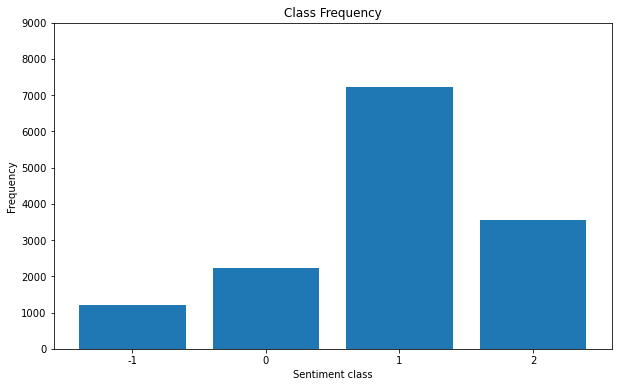

 1    7222
 2    3541
 0    2242
-1    1220
Name: sentiment, dtype: int64

In [42]:
plt.figure(figsize=(10, 6))
unique, counts = np.unique(df_train["sentiment"], return_counts=True)
print(unique, counts)
plt.bar(unique, counts)

plt.title("Class Frequency")
plt.xlabel("Sentiment class")
plt.ylabel("Frequency")
plt.xticks(ticks=[-1, 0, 1, 2], labels=[-1, 0, 1, 2])
plt.ylim(top=9000)

plt.show()
df_train["sentiment"].value_counts()

The graph shows the imbalanced data present per class label. <br>
It is expected that the model will be better at calssifying 1 than the other labels - due to having more observations to train on. The corresponding score values in the other classes might be lower for the same reason.

### Resampling
To account for the class imbalance (number of observations across different class labels are unevenly distributed) the data will be resampled (modifying the number of observations in each class). The majority class will be downsampled and upsampling applied to the minority classes.

In [43]:
def resample_data(df, class_size=4000, random_state=42):
    df_neg_1 = df[df["sentiment"] == -1]
    df_0 = df[df["sentiment"] == 0]
    df_1 = df[df["sentiment"] == 1]
    df_2 = df[df["sentiment"] == 2]
    
    # Downsample majority - sample with replacement, duiplicate values
    df_neg_1_upsampled = resample(df_neg_1,
                                 replace=True,
                                 n_samples=class_size,
                                 random_state=random_state)
    
    # Downsample majority - sample with replacement, duiplicate values
    df_0_upsampled = resample(df_0,
                                 replace=True,
                                 n_samples=class_size,
                                 random_state=random_state)
    
    # Upsample majority - sample without replacement, no duiplicate values
    df_1_downsampled = resample(df_1,
                                 replace=False,
                                 n_samples=class_size,
                                 random_state=random_state)
    
    # Downsample majority - sample with replacement, duiplicate values
    df_2_upsampled = resample(df_2,
                                 replace=True,
                                 n_samples=class_size,
                                 random_state=random_state)
    
    # Combine upsampled minority class with majority class
    resampled = [df_neg_1_upsampled, df_0_upsampled, df_1_downsampled, df_2_upsampled]
    df_resampled = pd.concat(resampled, axis=0)
    
    # Check dataframe and new class counts
    print(df_resampled.shape)
    print(df_resampled["sentiment"].value_counts())
    
    return df_resampled

In [44]:
df_train_resampled = resample_data(df_train, class_size=7222//2, random_state=42)

(14444, 3)
-1    3611
 2    3611
 1    3611
 0    3611
Name: sentiment, dtype: int64


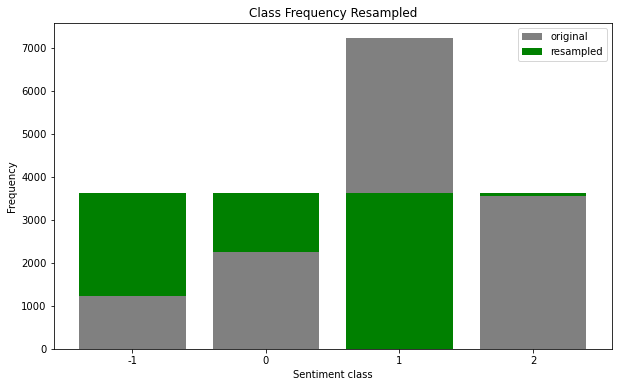

In [45]:
#Check distribution
heights = [len(df_train[df_train["sentiment"] == 1]), len(df_train[df_train["sentiment"] == 2]),
           len(df_train[df_train["sentiment"] == 0]), len(df_train[df_train["sentiment"] == -1])]

heights_resampled = [len(df_train_resampled[df_train_resampled["sentiment"] == 1]), len(df_train_resampled[df_train_resampled["sentiment"] == 2]),
           len(df_train_resampled[df_train_resampled["sentiment"] == 0]), len(df_train_resampled[df_train_resampled["sentiment"] == -1])]

labels = df_train["sentiment"].unique()

plt.figure(figsize=(10, 6))
plt.bar(labels, heights, color='grey')
plt.bar(labels, heights_resampled, color="green")
plt.bar(labels, heights, color='grey')
plt.bar(labels[0], heights_resampled[0], color="green")
plt.xticks(labels, ["1","2", "0", "-1"])
plt.title("Class Frequency Resampled")
plt.xlabel("Sentiment class")
plt.ylabel("Frequency")
plt.legend(["original", "resampled"])
plt.show()

Having resampled the data the class labels are now evenly distributed. The green sections of the bar plots show the amount of resampling that is applied per sentiment type.

### Tweets
The tweeted message are inspected per sentiment class more closely to get an idea of the data present. Also to determine if there are any specific information to extract to better train the model.

In [46]:
for tweet in df_train[df_train["sentiment"]==-1]["message"][:5]:
    print(tweet)
    print()

Sally Kohn’s latest evidence of climate change proves she is ‘not a smart person’ https://t.co/MhkzoGL9Vt via @twitchyteam Need we say more

@realDonaldTrump Carbon Tax is a Globalist idea to enslave the world's population. It is the whole reason for propagating global warming!

RT @SteveSGoddard: We had winds close to 100 MPH in the area this afternoon. I would blame climate change, except that this happens pr… 

@MissLizzyNJ lmao 😂 snowflakes ❄️ complaining about snowflakes ❄️ in winter =global warming 🤦‍♂️

RT @Dawn2334Dawn: This is ONE of Arnold Schwarzenegger's vehicles. He is now whining about climate change.
How's his maid...illegal or
http…



In [47]:
for tweet in df_train[df_train["sentiment"]==0]["message"][10:15]:
    print(tweet)
    print()

@uscgpacificnw @nsf These icebreaking ships are the primary cause of climate change. Let the arctic freeze over, &amp; stay away from there!

If global warming doesn't exist, why is club penguin shutting down? https://t.co/1oS6C8MFYx

RT @Cernovich: Is climate change real? https://t.co/FecIvOogma

RT @LDN_environment: We've a few short term opps working on climate change &amp; energy. Send us your CV or Q's to environment@london.gov.uk #h…

RT @MarkBaileyMP: Fed Energy/Envt Minister @JoshFrydenberg refused to allow term 'climate change' in #COAG Energy Council Communique despit…



In [48]:
for tweet in df_train[df_train["sentiment"]==1]["message"][20:25]:
    print(tweet)
    print()

I hate to say this, but *mental* health will be pretty low on the menu, when climate change hits food production an… https://t.co/KgFpw1hmPW

Hey There! Michael's vetted and approved market-based strategies for tackling climate change are supported by a majority of Cdns! #cdnpoli

RT @StarTalkRadio: First: The public understands climate change better than Congress. Why? #JohnHoldren @CoryBooker @neiltyson explain: htt…

RT @Honey17011: A guide to global warming, Paris pact and the US role #DemForce #TheResistance #UniteBlue https://t.co/RYiBLwAJZ4

Denying climate change ignores basic science



In [49]:
for tweet in df_train[df_train["sentiment"]==2]["message"][30:35]:
    print(tweet)
    print()

Trudeau must put emphasis on defence if he wants Trump onside for trade, climate change https://t.co/7tOd99M416 via @nationalpost

RT @thehill: Rahm Emanuel posts climate change webpage deleted by Trump administration https://t.co/Nhk4nVsUC1 https://t.co/tOmKxl3OWa

RT @Energydesk: Historic coal fall may have profound impact on global efforts to tackle climate change https://t.co/F4qqoRl6xm https://t.co…

RT @LiterateLiberal: Leading global warming deniers just told us what they want trump to do https://t.co/tkZVNzDDd3 via @MotherJones

RT @pablorodas: #CLIMATEchange #p2 RT West Coast states to fight climate change even if Trump does not. https://t.co/dYixU8TxaK…



### Summary of what see

### Tweet Length

In [50]:
def char_count(df):
    df = df.copy()
    df["char_count"] = df["message"].apply(lambda x: len(x))
    
    return df

In [51]:
df_chars = char_count(df_train)
df_chars.head()

,sentiment,message,tweetid,char_count
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,140
1,1,It's not like we lack evidence of anthropogenic global warming,126103,62
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,140
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,99
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,122


<AxesSubplot:xlabel='char_count', ylabel='Count'>

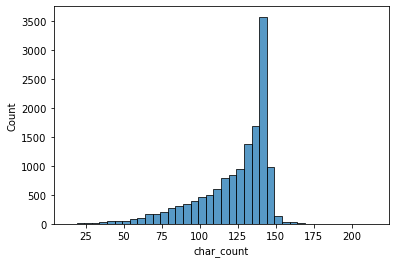

In [52]:
sns.histplot(data=df_chars, x="char_count", binwidth=5)

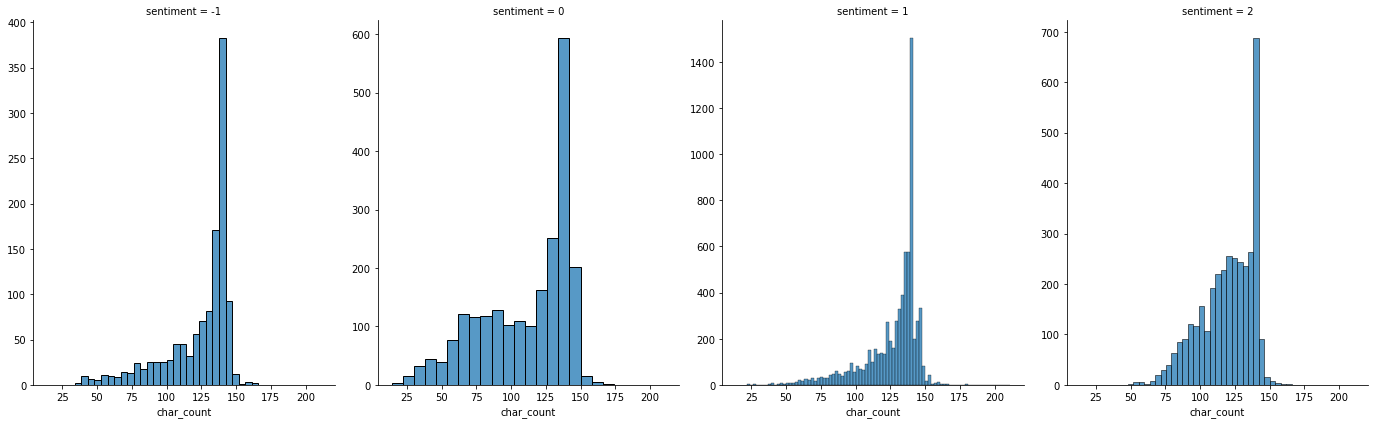

In [53]:

g = sns.FacetGrid(df_chars, col="sentiment", sharey=False, height=6, aspect= 0.8)
g.map(sns.histplot, 'char_count')

## Word Cloud
Is a cloud filled with lots of words in different sizes, which represent the frequency or the importance of each word. It assists with analyzing the importance of certain words to a specific class label.


The function contains all the preprocessing steps required for initial analyses.

#### Preprocessing Steps for Word Cloud
The following processing steps are selected for the Word Cloud.

In [54]:
def preprocess_WC(df):
    df = df.copy()
    
    df = replace_urls(df)
    df = to_lower(df)
    df = remove_all_punctuation(df)
    return df

In [55]:
df_train_clean = preprocess_WC(df_train)
df_test_clean = preprocess_WC(df_test)

### All Sentiments

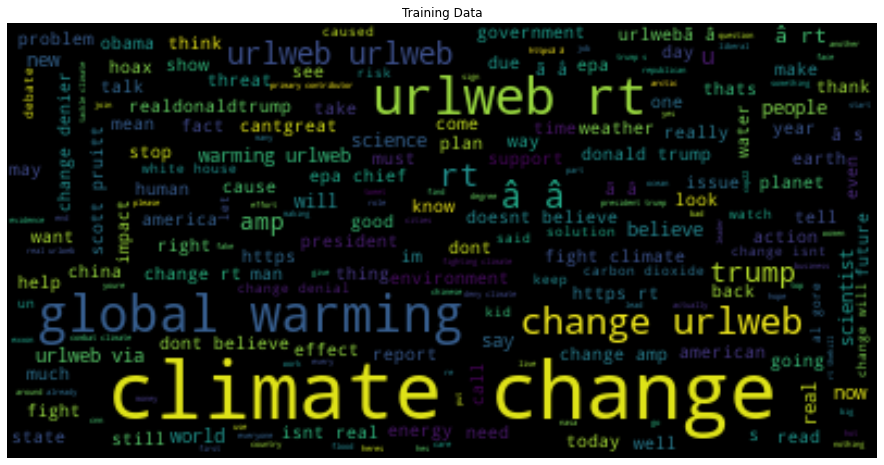

In [56]:
text = " ".join(message for message in df_train_clean["message"])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Training Data")
plt.show()

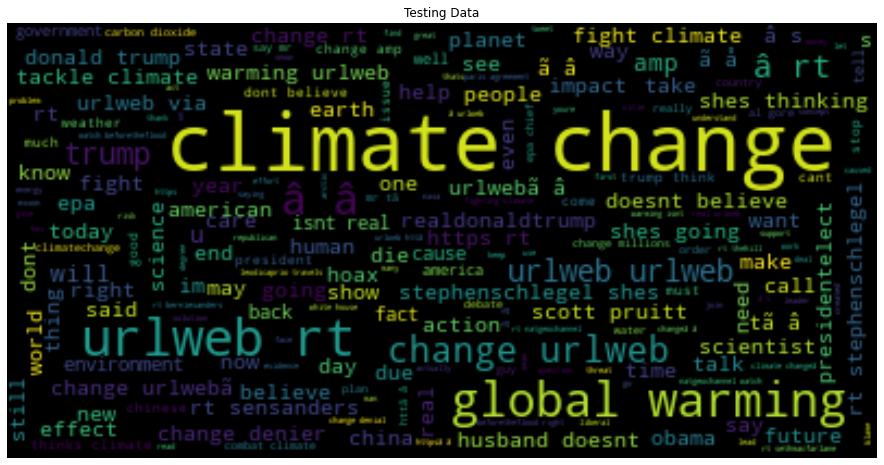

In [57]:
text = " ".join(message for message in df_test_clean["message"])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Testing Data")
plt.show()

### Per Sentiment

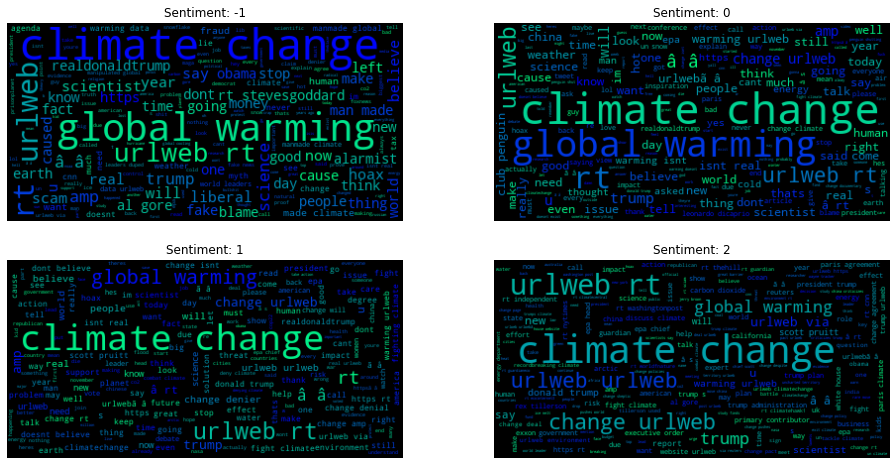

In [58]:
plt.figure(figsize=(16, 8))
for i, v in enumerate([-1, 0, 1, 2]):
    text = " ".join(message for message in df_train_clean[df_train_clean["sentiment"]==v]["message"])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(colormap="winter").generate(text)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Sentiment: {v}")
    plt.axis("off")
plt.show()

From the Word Clouds above the following information is gained:<br>
<br>For all sentiments: "climate change", "global warming", "urlweb rt", "rt", "change urlweb", "urlweb urlweb", "â" are the words that occur most frequently. The following has to be investigated:<br>
- Strange characters such as the "â" and stopwords are present - these might let the model train on irrelevant information.
- People's name such as "obama", "trump" and "donald trump" occur which can be extracted to better train the model.
- Try to extract more information from the urlweb links - currently all of the links are replaced with urlweb.
- Retweeted Tweets occur frequently in the data.
- The words that occur most frequent should be checked if they contribute to a specific sentiment class.


Checking per sentiment: The word "climate change" seems to be present in each sentiment label - making it a common feature that does not seem to classify only one type of sentiment class. There is also a high presence of the following words:<br>
- "global warming"
- "urlweb"
- "rt"
- "trump" <br>

These need to be investigated further to determine relevance and how they can be used to better train the model. This requires some additional preprocessing steps and feature extraction/engineering to remove noise and ensure the most relevent features are used to train the data. This will help predict each sentiment class more accurately.<br>

As an initial step, the following words will be removed and the Word Clouds will be plotted again.

In [59]:
common_words_remove = ["climatechange", "climate", "change" ]

In [60]:
def drop_words(df, common_words_remove):
    df["message"] = df["message"].apply(lambda x: x.split())
    df["message"] = df["message"].apply(lambda row: " ".join([w for w in row if w not in common_words_remove]))
    return df

In [61]:
df_train_clean_dw = drop_words(df_train_clean, common_words_remove)
df_test_clean_dw = drop_words(df_test_clean, common_words_remove)

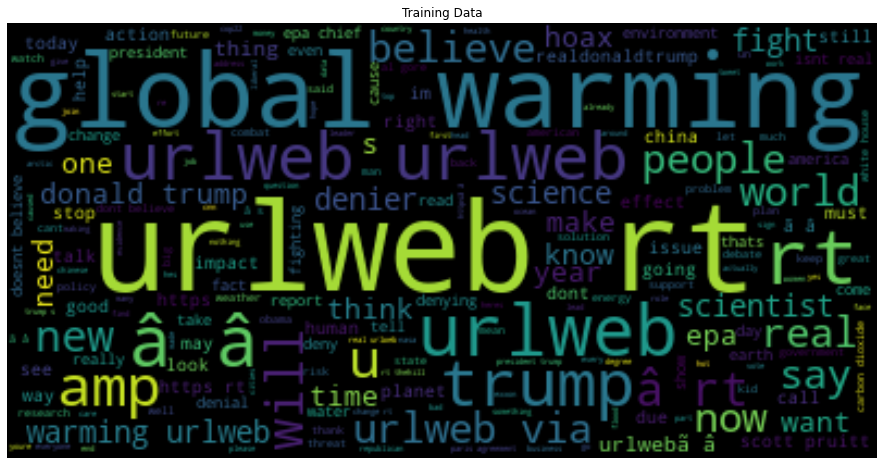

In [62]:
text = " ".join(message for message in df_train_clean_dw["message"])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Training Data")
plt.show()

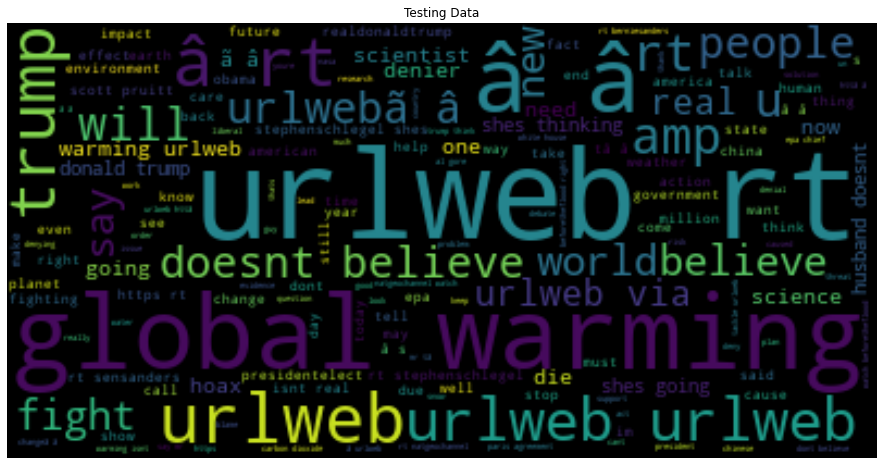

In [63]:
text = " ".join(message for message in df_test_clean_dw["message"])
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Testing Data")
plt.show()

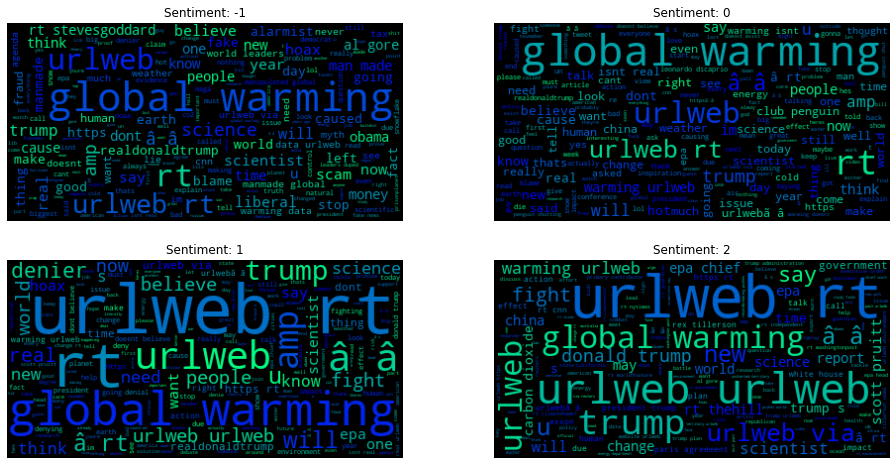

In [64]:
plt.figure(figsize=(16, 8))
for i, v in enumerate([-1, 0, 1, 2]):
    text = " ".join(message for message in df_train_clean_dw[df_train_clean_dw["sentiment"]==v]["message"])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(colormap="winter").generate(text)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Sentiment: {v}")
    plt.axis("off")
plt.show()

Resample? Still some frequent words?

## Word Frequency
After investigation the data with Word Clouds it is decided to go into more depth to visualise these words and gain a better understanding of the wrods present. The distribution of the words will be checked. The bag of words function is required for this.

### Bag of Words
The preprocessing required for the bag of words function:

In [65]:
def preprocessing_bow(df):
    df = df.copy()
    df = replace_urls(df)
    df = to_lower(df)
    df = remove_all_punctuation(df)
    df = tree_tokenise(df)
    return df

In [66]:
df_train_clean = preprocessing_bow(df_train)
df_test_clean = preprocessing_bow(df_test)

The Bag of Words model is the simplest method to extract features; it constructs a word presence feature set from all the words in the text, indicating the number of times each word has appeared.

In [67]:
def bag_of_words_count(words, word_dict={}):
    """ This function takes in a list of words and returns a dictionary 
    with each word as a key, and the value represents the number of 
    times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

In [68]:
sentiment_types = list(df_train["sentiment"].unique())

In [69]:
sentiment_types

[1, 2, 0, -1]

A dictionary is created per sentiment type of all the words present from the bag of words count function - it is stored in the dictionary `sentiment_bow`

In [70]:
sentiment_bow = {}
for st in sentiment_types:
    df = df_train_clean.groupby("sentiment")
    sentiment_bow[st] = {}
    for row in df.get_group(st)["message"]:
        sentiment_bow[st] = bag_of_words_count(row, sentiment_bow[st])

A list (`all_words`) is created of all the unique words present in the tweet message for all the sentiment label outcomes.

In [71]:
all_words = set()
for st in sentiment_types:
    for word in sentiment_bow[st]:
        all_words.add(word)

The set of all the words present in the message column of the dataframe is added to the dictionary `sentiment_bow` and stored under the key `all` for analyses.

In [72]:
sentiment_bow["all"] = {}
for st in sentiment_types:
    for word in all_words:
        if word in sentiment_bow[st].keys():
            if word in sentiment_bow["all"]:
                sentiment_bow["all"][word] += sentiment_bow[st][word]
            else:
                sentiment_bow["all"][word] = sentiment_bow[st][word]
                

Below shows the total count of unique words present in the dataframe.

In [73]:
total_words = sum([val for val in sentiment_bow["all"].values()])
total_words

246225

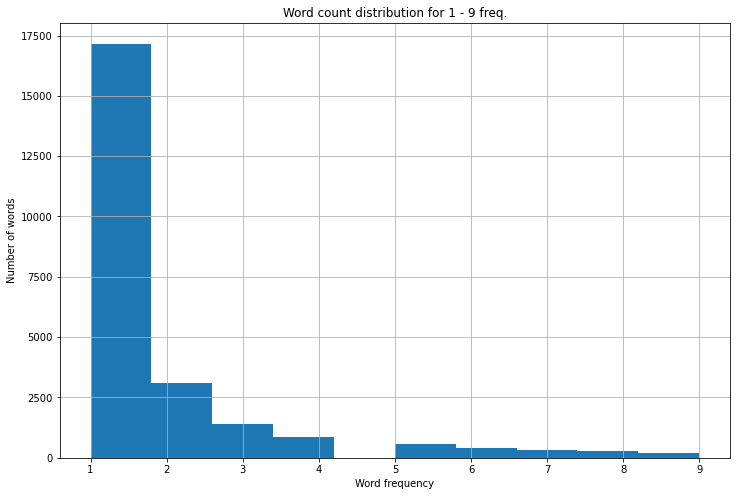

In [74]:
plt.figure(figsize=(12, 8))
_ = plt.hist([val for val in sentiment_bow["all"].values() if val < 10], bins=10)
plt.title("Word count distribution for 1 - 9 freq.")
plt.ylabel("Number of words")
plt.xlabel("Word frequency")
plt.grid()

In [75]:
count_rare_words = len([val for val in sentiment_bow["all"].values() if val == 1])
count_rare_words

17164

In [76]:
occur_rare_words = sum([val for val in sentiment_bow["all"].values() if val == 1])
occur_rare_words

17164

In [77]:
occur_rare_words / total_words * 100

6.970859985785359

In [78]:
rare_words = [key for key, val in sentiment_bow["all"].items() if val==1]
print(rare_words[:100])

['indepen…', 'coolest', 'hurricaneã¢â‚¬â¦', 'administr…', 'yes…', 'amcafee', '“value”', 'bradleym4', 'chances', 'lynncinnamon', 'motorygin', 'natparkundrgrnd', 'depressingly', 'abiwilks', 'ryall', 'crazygabey', 'sustainabledoc', 'sniff', 'inhabit', 'consistent', 'socking', 'ã¢â‚¬å“donald', 'impediment', 'rebootdnc', 'respondtweet', '2067', 'pollutionwe', 'snowfl…', 'krissacrebleu', 'snvworld', 'helll', 'merrilllynched', 'murderers', 'magicjohnson', 'hellaroasty', 'chetanbhagat', 'funny…', 'johnmorganesq', 'sangyeh', '🌎', 'wsj6269j', 'localgov', 'vibrant', 'hellexpanding', 'infusion', 'wickedbeaute', 'take2', 'bluepurplerain', 'trump2016', 'cookiebo', 'stoptrump2020', 'setting4success', 'evidence…', 'ar', 'concretely', 'liliangreenwood', 'lean', 'tanehisicoates', 'reames', 'calexit', 'atheistic1', 'harvardenvhlth', 'brookewmckeever', 'alphageekst3r', 'williscj', 'bharren', 'billycadden', 'donaldtrumpis', 'pasmsu2', 'scienceteens', '“this', 'smallholder', 'antoniobanderas', 'beckon', 'el

It seems that the data can be cleaned more effectively to extract words that can better train the model. Some of the words present cary no meaning and is not even English words - making it difficult for the model to be able to classify tweeted messages to a specific sentiment.

In [79]:
count_small_words = len([val for val in sentiment_bow["all"].values() if val > 1 and val <= 10])
count_small_words

7262

In [80]:
occur_small_words = sum([val for val in sentiment_bow["all"].values() if val > 1 and val <= 10])
occur_small_words

26928

In [81]:
occur_small_words / total_words * 100

10.936338714590315

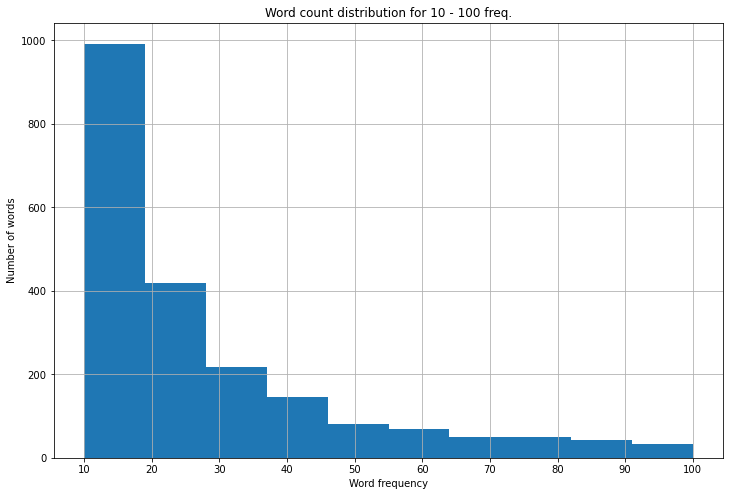

In [82]:
plt.figure(figsize=(12, 8))
_ = plt.hist([val for val in sentiment_bow["all"].values() if val >= 10 and val <= 100], bins=10)
plt.title("Word count distribution for 10 - 100 freq.")
plt.ylabel("Number of words")
plt.xlabel("Word frequency")
plt.xticks(range(10,101,10))
plt.grid()

In [83]:
count_med_words = len([val for val in sentiment_bow["all"].values() if val > 1 and val <= 100])
count_med_words

9196

In [84]:
occur_med_words = sum([val for val in sentiment_bow["all"].values() if val > 1 and val <= 100])
occur_med_words

82726

In [85]:
occur_med_words / total_words * 100

33.597725657427155

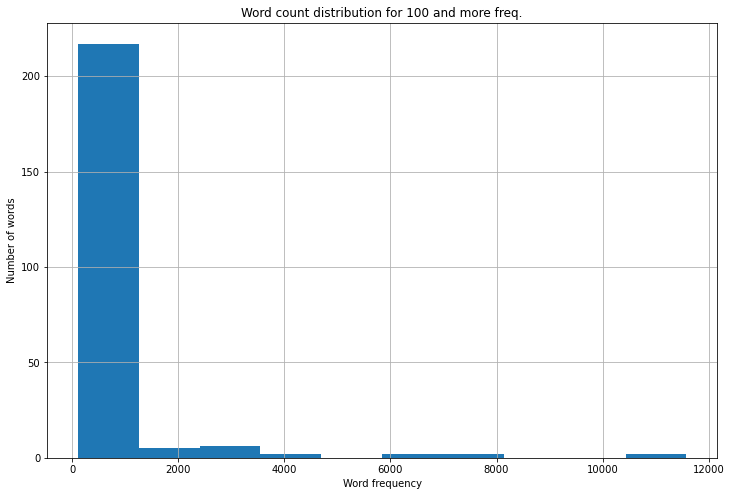

In [86]:
plt.figure(figsize=(12, 8))
_ = plt.hist([val for val in sentiment_bow["all"].values() if val > 100], bins=10)
plt.title("Word count distribution for 100 and more freq.")
plt.ylabel("Number of words")
plt.xlabel("Word frequency")
plt.grid()

In [87]:
count_high_words = len([val for val in sentiment_bow["all"].values() if val > 100])
count_high_words

236

In [88]:
occur_high_words = sum([val for val in sentiment_bow["all"].values() if val > 100])
occur_high_words

146335

In [89]:
occur_high_words / total_words * 100 + occur_med_words / total_words * 100

93.02914001421465

From the analyses above most of the words present in the corpus are words with a frequency 10 and more - totals to 93%. The plots show words that only occur once in the tweet message column can be removed without losing too much data. These single occuring words only account for 6,7% of all the words present. It seems that a sweet spot for removing words that are not that valuable lies between a frequency of 1 to 10 words. Removing words with a frequency above 10 will skrink the amount of training features too much making the model too bias.

### Testing Data
The testing dataframe is also inspected - based on word frequency.

In [90]:
testdf_bow_all = {}
for row in df_test_clean["message"]:
    testdf_bow_all = bag_of_words_count(row, testdf_bow_all)

In [91]:
testdf_bow_all

{'europe': 17,
 'will': 656,
 'now': 302,
 'be': 629,
 'looking': 21,
 'to': 4797,
 'china': 197,
 'make': 196,
 'sure': 47,
 'that': 1033,
 'it': 797,
 'is': 2934,
 'not': 781,
 'alone': 10,
 'in': 2445,
 'fighting': 100,
 'climate': 8609,
 'change…': 120,
 'urlweb': 5567,
 'combine': 1,
 'this': 712,
 'with': 648,
 'the': 5088,
 'polling': 2,
 'of': 2891,
 'staffers': 6,
 're': 26,
 'change': 8147,
 'and': 2009,
 'womens': 14,
 'rights': 86,
 'you': 931,
 'have': 616,
 'a': 2816,
 'fascist': 10,
 'state': 72,
 'scary': 21,
 'unimpeachable': 2,
 'evidence': 78,
 'already': 51,
 'here': 168,
 'itstimetochange': 4,
 'climatechange': 123,
 'zeroco2': 4,
 'karoli': 1,
 'morgfair': 2,
 'osborneink': 1,
 'dailykos': 5,
 'putin': 19,
 'got': 65,
 'too': 97,
 'jill': 9,
 'trump': 1332,
 'doesnt': 527,
 'believe': 775,
 'at': 439,
 'all': 366,
 'thinks': 179,
 'its': 531,
 's': 13,
 'hoax': 290,
 'rt': 6376,
 'fakewillmoore': 1,
 'female': 3,
 'orgasms': 1,
 'cause': 119,
 'global': 2522,
 'wa

In [92]:
total_words = sum([val for val in testdf_bow_all.values()])
total_words

185510

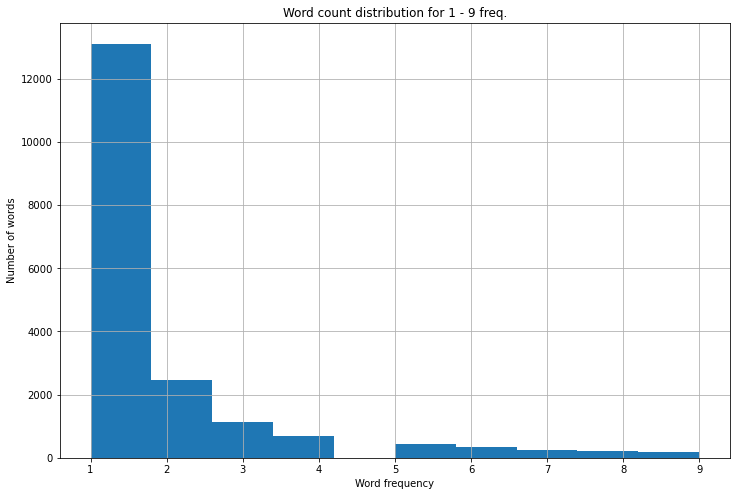

In [93]:
plt.figure(figsize=(12, 8))
_ = plt.hist([val for val in testdf_bow_all.values() if val < 10], bins=10)
plt.title("Word count distribution for 1 - 9 freq.")
plt.ylabel("Number of words")
plt.xlabel("Word frequency")
plt.grid()

In [94]:
count_rare_words = len([val for val in testdf_bow_all.values() if val == 1])
count_rare_words

13117

In [95]:
occur_rare_words = sum([val for val in testdf_bow_all.values() if val == 1])
occur_rare_words

13117

In [96]:
occur_rare_words / total_words * 100

7.0707778556412055

In [97]:
count_small_words = len([val for val in testdf_bow_all.values() if val > 1 and val <= 10])
count_small_words

5820

In [98]:
occur_small_words = sum([val for val in testdf_bow_all.values() if val > 1 and val <= 10])
occur_small_words

21659

In [99]:
occur_small_words / total_words * 100

11.675381381057624

In [100]:
rare_words = [key for key, val in testdf_bow_all.items() if val==1]
print(rare_words[:100])

['combine', 'karoli', 'osborneink', 'fakewillmoore', 'orgasms', 'sarcastic', 'muzzles', 'gov’t', 'bmastenbrook', 'comp', 'ethics', 'lecturer', 'indonesian', 'ipsnews', 'aid4ag', '100isnow', 'tillerson…', 'recommendations', 'scotclimate…', 'yajairaxlove', 'bigoilowned', 'chairman', '‘declaration', 'war’', 'injculbard', 'martinstiff', 'earthplannr', 'ackley', 'referring', 'joshgnosis', 'ashby', 'culleton', 'journos', 'walks', 'allan', 'savory', '94kristin', 'mymodernmet', 'thevonwong', 'lavaã¢â‚¬â¦', 'scream', 'hatred', 'vanished', 'lizzydior', 'operative', 'crosses', 'wishlist', 'item–exp…', 'ã¢â‚¬å“shredã¢â‚¬ï†\x9d', 'assemblyman', 'medical', 'communitys', 'davidrivett1', '‘lecturing’', 'aoki', 'rights…', 'liontornado', 'energ…', 'worryingabout', 'morgangary', '77', 'csironews', 'jacobahernz', 'vbs269', 'annieblackmore', 'windbag', 'jaywick', 'owen…', 'fertile', 'rfstew', 'doug', 'edmeades', 'rowarths', 'partner', 'crapo4senate', 'survived', 'leahyparks', 'passion', 'brothersbaric', 'p

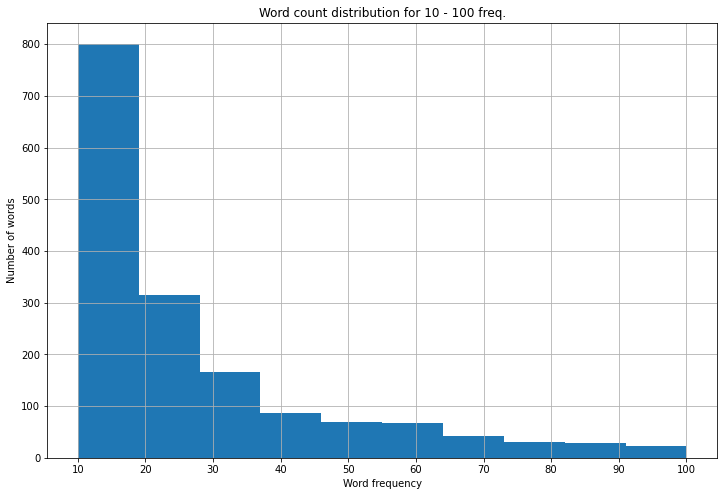

In [101]:
plt.figure(figsize=(12, 8))
_ = plt.hist([val for val in testdf_bow_all.values() if val >= 10 and val <= 100], bins=10)
plt.title("Word count distribution for 10 - 100 freq.")
plt.ylabel("Number of words")
plt.xlabel("Word frequency")
plt.xticks(range(10,101,10))
plt.grid()

In [102]:
count_med_words = len([val for val in testdf_bow_all.values() if val > 1 and val <= 100])
count_med_words

7310

In [103]:
occur_med_words = sum([val for val in testdf_bow_all.values() if val > 1 and val <= 100])
occur_med_words

63854

In [104]:
occur_med_words / total_words * 100

34.42078594145868

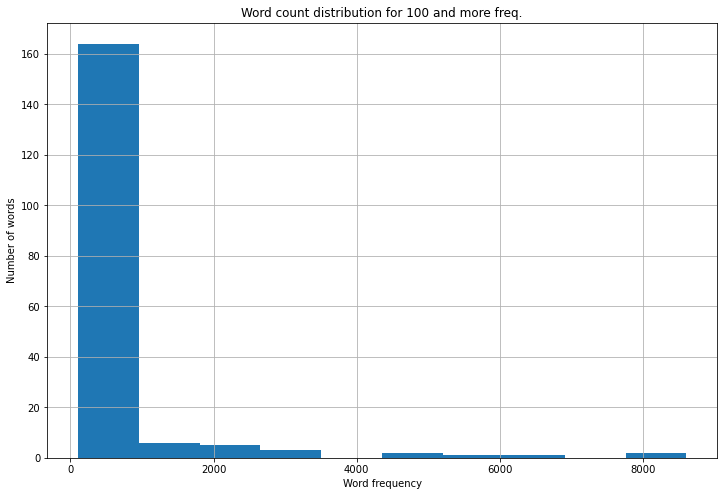

In [105]:
plt.figure(figsize=(12, 8))
_ = plt.hist([val for val in testdf_bow_all.values() if val > 100], bins=10)
plt.title("Word count distribution for 100 and more freq.")
plt.ylabel("Number of words")
plt.xlabel("Word frequency")
plt.grid()

In [106]:
count_high_words = len([val for val in testdf_bow_all.values() if val >= 10])
count_high_words

1811

In [107]:
occur_high_words = sum([val for val in testdf_bow_all.values() if val >= 10])
occur_high_words

152104

The testing data seems to be very similiar in terms of word frequency to the training data.

## Extract Hashtags and Mentions

In [108]:
def preprocess_eda(df):
    df = df.copy()
    
    df = replace_urls(df)
    df = to_lower(df)
    df = remove_all_punctuation(df)
    df = tree_tokenise(df)
    df = remove_stop_words(df)
    df = join_tokens(df)
    return df

In [109]:
df_train_clean = preprocess_eda(df_train)
df_test_clean = preprocess_eda(df_test)

In [110]:
def get_hashtags(df):
    df["hashtags"] = df["message"].apply(lambda row: [hashtag[1:] for hashtag in row if hashtag[0] == "#" and len(hashtag) > 1])
    df["hashtags"] = df["hashtags"].apply(lambda hashtag: np.nan if len(hashtag)==0 else hashtag)
    return df 

In [111]:
def get_mention(df):
    df["mentions"] = df["message"].apply(lambda row: [mention[1:] for mention in row if mention[0] == "@" and len(mention) > 1])
    df["mentions"] = df["mentions"].apply(lambda hashtag: np.nan if len(hashtag)==0 else hashtag)
    return df 

In [112]:
def preprocessing_extract(df):
    df = df.copy()
    df = replace_urls(df)
    df = to_lower(df)
    df = tweet_tokenise(df)
    return df

In [113]:
df_train_clean = preprocessing_extract(df_train)
df_test_clean = preprocessing_extract(df_test)
df_train_clean = get_hashtags(df_train_clean)
df_test_clean = get_hashtags(df_test_clean)
df_train_clean = get_mention(df_train_clean)
df_test_clean = get_mention(df_test_clean)

In [114]:
df_train_clean.head()

,sentiment,message,tweetid,hashtags,mentions
0,1,"[polyscimajor, epa, chief, doesn't, think, carbon, dioxide, is, main, cause, of, global, warming, and, .., wait, ,, what, !, ?, url-web, via, @mashable]",625221,NaN,[mashable]
1,1,"[it's, not, like, we, lack, evidence, of, anthropogenic, global, warming]",126103,NaN,NaN
2,2,"[rt, @rawstory, :, researchers, say, we, have, three, years, to, act, on, climate, change, before, it, ’, s, too, late, url-web, url-web, …]",698562,NaN,[rawstory]
3,1,"[#todayinmaker, #, wired, :, 2016, was, a, pivotal, year, in, the, war, on, climate, change, url-web]",573736,[todayinmaker],NaN
4,1,"[rt, @soynoviodetodas, :, it's, 2016, ,, and, a, racist, ,, sexist, ,, climate, change, denying, bigot, is, leading, in, the, polls, ., #electionnight]",466954,[electionnight],[soynoviodetodas]


In [115]:
def get_hashtag_df(df):
    df = df[["sentiment", "hashtags"]]
    df = df[df["hashtags"].notnull()]
    return df

In [116]:
def get_mention_df(df):
    df = df[["sentiment", "mentions"]]
    df = df[df["mentions"].notnull()]
    return df

In [117]:
df_hashtags_all = get_hashtag_df(df_train_clean)
df_hashtags_all.head()

,sentiment,hashtags
3,1,[todayinmaker]
4,1,[electionnight]
13,1,[climatemarch]
20,1,[saveourplanet]
21,1,"[cop22, earthtomarrakech]"


In [118]:
df_mentions_all = get_mention_df(df_train_clean)
df_mentions_all.head()

,sentiment,mentions
0,1,[mashable]
2,2,[rawstory]
4,1,[soynoviodetodas]
6,1,[thenation]
7,1,[makeandmendlife]


In [119]:
def get_hashtag_count(df):
    all_hashtags = sum(df["hashtags"], [])
    freq_count = nltk.FreqDist(all_hashtags)  
    df = pd.DataFrame({"hashtags": list(freq_count.keys()), "count": list(freq_count.values())})
    return df

In [120]:
def get_mention_count(df):
    all_mentions = sum(df["mentions"], [])
    freq_count = nltk.FreqDist(all_mentions)  
    df = pd.DataFrame({"mentions": list(freq_count.keys()), "count": list(freq_count.values())})
    return df

In [121]:
df_hashtags_count_all = get_hashtag_count(df_hashtags_all)
df_hashtags_count_all.head()

,hashtags,count
0,todayinmaker,1
1,electionnight,6
2,climatemarch,25
3,saveourplanet,1
4,cop22,70


In [122]:
df_mentions_count_all = get_mention_count(df_mentions_all)
df_mentions_count_all.head()

,mentions,count
0,mashable,20
1,rawstory,7
2,soynoviodetodas,1
3,thenation,3
4,makeandmendlife,1


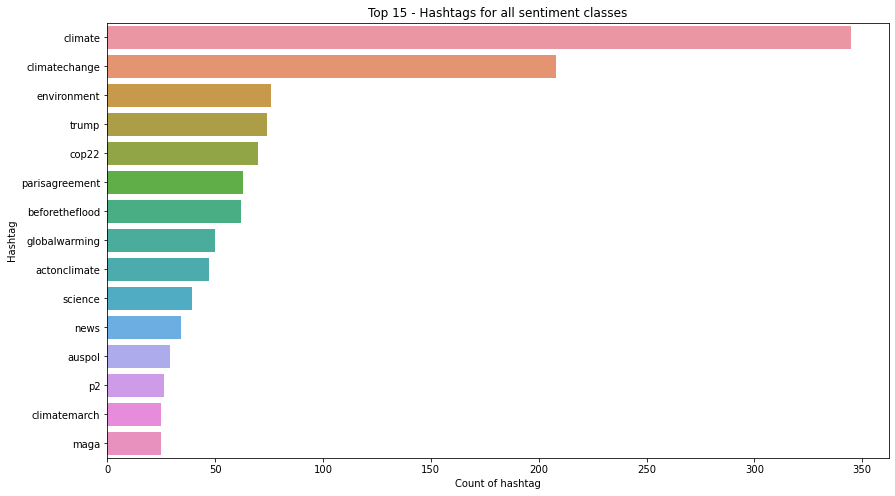

In [123]:
df=df_hashtags_count_all.nlargest(columns="count", n=15)
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df, y="hashtags", x="count")
plt.title("Top 15 - Hashtags for all sentiment classes")
plt.xlabel("Count of hashtag")
plt.ylabel("Hashtag")
plt.show()

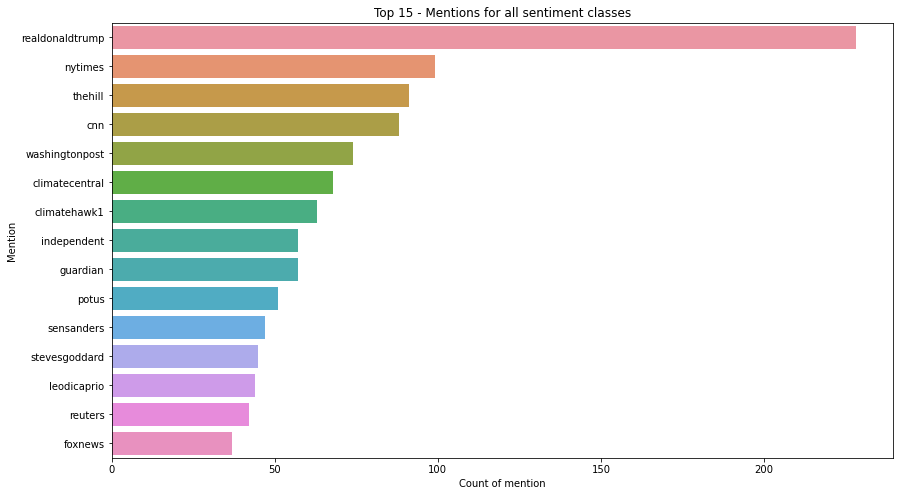

In [124]:
df=df_mentions_count_all.nlargest(columns="count", n=15)
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df, y="mentions", x="count")
plt.title("Top 15 - Mentions for all sentiment classes")
plt.xlabel("Count of mention")
plt.ylabel("Mention")
plt.show()

In [125]:
df_hashtags_count_0 = get_hashtag_count(df_hashtags_all[df_hashtags_all["sentiment"]==0])
df_hashtags_count_1 = get_hashtag_count(df_hashtags_all[df_hashtags_all["sentiment"]==1])
df_hashtags_count_m1 = get_hashtag_count(df_hashtags_all[df_hashtags_all["sentiment"]==-1])
df_hashtags_count_2 = get_hashtag_count(df_hashtags_all[df_hashtags_all["sentiment"]==2])

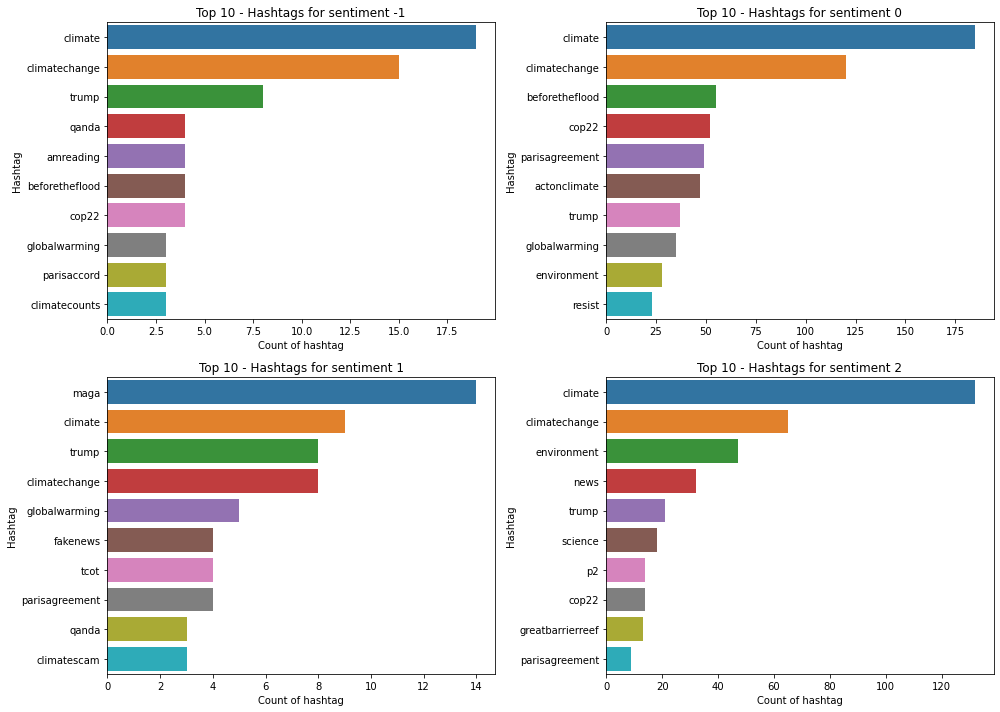

In [126]:
plt.figure(figsize=(14, 10))
s = [-1, 0, 1, 2]
for i, df in enumerate([df_hashtags_count_0, df_hashtags_count_1, df_hashtags_count_m1, df_hashtags_count_2]):
    
    plt.subplot(2, 2, i+1)
    ax = sns.barplot(data=df.nlargest(columns="count", n=10), y="hashtags", x="count")
    plt.title(f"Top 10 - Hashtags for sentiment {s[i]}")
    plt.xlabel("Count of hashtag")
    plt.ylabel("Hashtag")
plt.tight_layout()
plt.show()

In [127]:
df_mentions_count_0 = get_mention_count(df_mentions_all[df_mentions_all["sentiment"]==0])
df_mentions_count_1 = get_mention_count(df_mentions_all[df_mentions_all["sentiment"]==1])
df_mentions_count_m1 = get_mention_count(df_mentions_all[df_mentions_all["sentiment"]==-1])
df_mentions_count_2 = get_mention_count(df_mentions_all[df_mentions_all["sentiment"]==2])

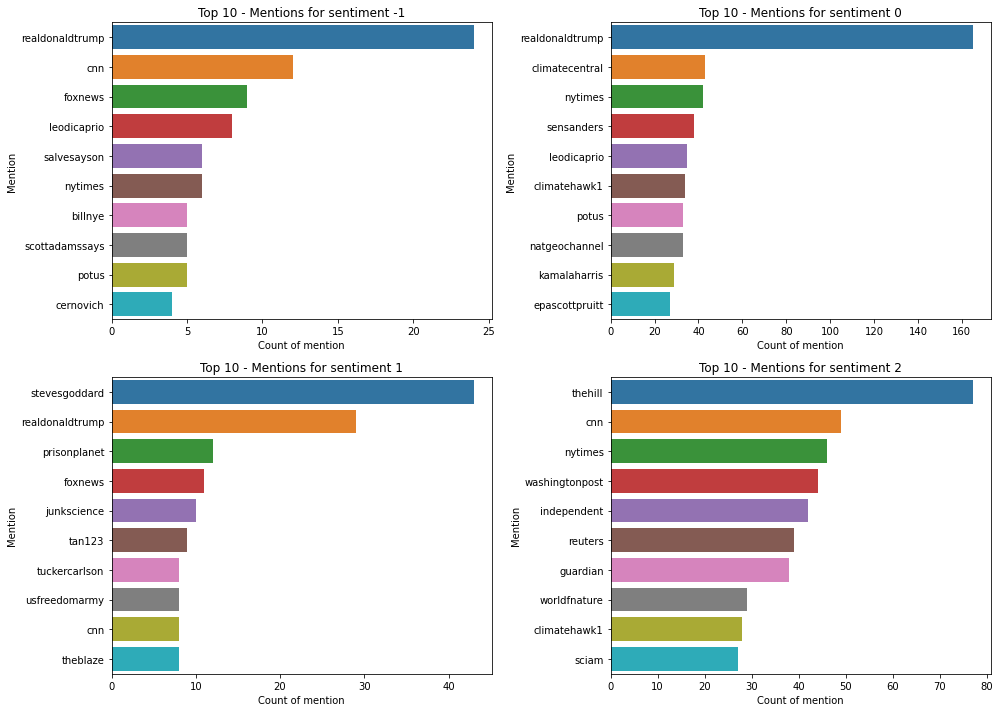

In [128]:
plt.figure(figsize=(14, 10))
s = [-1, 0, 1, 2]
for i, df in enumerate([df_mentions_count_0, df_mentions_count_1, df_mentions_count_m1, df_mentions_count_2]):
    
    plt.subplot(2, 2, i+1)
    ax = sns.barplot(data=df.nlargest(columns="count", n=10), y="mentions", x="count")
    plt.title(f"Top 10 - Mentions for sentiment {s[i]}")
    plt.xlabel("Count of mention")
    plt.ylabel("Mention")
plt.tight_layout()
plt.show()

### Explain

# !!!!!!!!! Mostly complete up to here.

# More Data Cleaning
After EDA - if requried to perform more cleaning from insights of EDA

More extra imports


### ??

### Get title from urls

(play with later)

?names of Youtube videos?

In [129]:
ss = 'nge before it’s too late https://t.co/WdT0KdUr2f http nge before it’s too late https://t.co/WdT0KdUr2f http'

In [130]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
re.findall(pattern_url, ss)

NameError: name 're' is not defined

In [131]:
import requests
from bs4 import BeautifulSoup as bs
import re

def get_url_heading(message):
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    urls = re.findall(pattern_url, message)
    if urls:
        titles = ""
        for url in urls:
            try:
                print(url)
                r = requests.get(url)
                soup = bs(r.content, 'lxml')
                url_title = soup.select_one('title').text
                titles = titles + "" + url_title
            except:
                pass
        return titles
    return ""

In [132]:
df_train[df_train["sentiment"]==1]["message"][0:5].apply(get_url_heading)

https://t.co/yeLvcEFXkC
https://t.co/44wOTxTLcD
https://t.co/ggLZVNYjun
https://t.co/7AFE2mAH8j


0    
1    
3    
4    
5    
Name: message, dtype: object

In [133]:
df_train

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954
...,...,...,...
15813,1,RT @thinkprogress: EPA head falsely claims carbon emissions aren’t the cause of global warming\r\nhttps://t.co/owbqKlSyMx https://t.co/i19vAgE…,442853
15814,1,"RT @ezlusztig: They took down the material on global warming, LGBT rights, and health care. But now they're hocking Melania's QVC. https://…",22001
15816,0,notiven: RT: nytimesworld :What does Trump actually believe about climate change? Rick Perry joins other aides in … https://t.co/0Mp2,384248
15817,-1,RT @sara8smiles: Hey liberals the climate change crap is a hoax that ties to #Agenda2030.\r\nThe Climate is Being Changed byÃ¢â‚¬Â¦,819732


In [134]:
df_train['message'][:5]

0    PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable
1                                                                                  It's not like we lack evidence of anthropogenic global warming
2    RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…
3                                             #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD
4                      RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight
Name: message, dtype: object

### ??

# Feature Extraction
Text feature extraction is the process of transforming what is essentially a list of words into a feature set that is usable by a classifier. The NLTK classifiers expect dict style feature sets therefore transform text into a dict.

The following preprocesing is required:

In [135]:
df_train_clean = replace_urls(df_train.copy())
df_test_clean = replace_urls(df_test.copy())
df_train_clean = to_lower(df_train_clean)
df_test_clean = to_lower(df_test_clean)
df_train_clean = keep_normal_chars(df_train_clean)
df_test_clean = keep_normal_chars(df_test_clean)
df_train_clean = remove_all_punctuation(df_train_clean)
df_test_clean = remove_all_punctuation(df_test_clean)
df_train_clean = tweet_tokenise(df_train_clean)
df_test_clean = tweet_tokenise(df_test_clean)
df_train_clean = df_stemma(df_train_clean)
df_test_clean = df_stemma(df_test_clean)
df_train_clean = df_lemma(df_train_clean)
df_test_clean = df_lemma(df_test_clean)
df_train_clean = remove_stop_words(df_train_clean)
df_test_clean = df_lemma(df_test_clean)
df_train_clean = join_tokens(df_train_clean)
df_test_clean = join_tokens(df_test_clean)

The following imports are require for feature extraction:

In [136]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

### CountVectorizer
The CountVectorizer converts a collection of text documents to a matrix of token counts. It returns all the tokens in the documents and how many times they occur - as integer values. 

In [137]:
def get_count_vec(X_train, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None):
    vector = CountVectorizer(
        ngram_range=ngram_range, 
        max_df=max_df, 
        min_df=min_df, 
        max_features=max_features
    )
    vector.fit(X_train)
    return vector

### TfidfVectorizer
Whereas the TfidfVectorizer penalises common words and returns a float value. It consisits of the term frequency multiplied with the inverse document frequency.

In [138]:
def get_tfidf_vec(X_train, ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None):
    vector = TfidfVectorizer(
        ngram_range=ngram_range, 
        max_df=max_df, 
        min_df=min_df, 
        max_features=max_features
    )
    vector.fit(X_train)
    return vector

In [139]:
vector_c = get_count_vec(df_train_clean["message"])
X_train_t = vector_c.transform(df_train_clean["message"])

### Train Test Split
The train test split function is to split the data into a training set (for model training) and a validate/test set to check the preformance of the trained model on unseen data.

In [140]:
def tt_split(X, y):
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return (X_train, y_train), (X_test, y_test)

In [141]:
X_train_c = get_count_vec(df_train_clean["message"]).transform(df_train_clean["message"])

In [142]:
(X_train, y_train), (X_test, y_test) = tt_split(X_train_c, df_train_clean["sentiment"])

In [143]:
print("observations and features:", "\nTrain data X:", X_train.shape, "\nTrain data y:", y_train.shape)

observations and features: 
Train data X: (11380, 20725) 
Train data y: (11380,)


In [144]:
print("observations and features:", "\nTest data X:", X_test.shape, "\nTest data y:", y_test.shape)

observations and features: 
Test data X: (2845, 20725) 
Test data y: (2845,)


# Modelling and Evaluation
Several models trained with each their own required preprocessing steps. Variable selection and feature engineering process to select best model based on performance metrics - F-score

From the calssification report the first classification metric is: **overall accuracy**, which is calculated according to the following formula:

$$Accuracy =  \frac{Correct\space predictions}{Total\space predictions} = \frac{TP + \space TN}{TP \space + \space TN \space + \space FP \space + \space FN}$$
#### Precision
When it predicts _yes_, how often is it correct? 

$$ Precision = \frac{TP}{TP \space + FP} = \frac{TP}{Total \space Predicted \space Positive} $$
#### Recall
When the outcome is actually _yes_, how often is it predicted as such?

$$ Recall = \frac{TP}{TP \space + FN} = \frac{TP}{Total \space Actual \space Positive}$$
#### F1 Score
Weighted average of precision and recall. 

$$F_1 = 2 \times \frac {Precision \space \times \space Recall }{Precision \space + \space Recall }$$
F1 Score might be a better measure to use if for a balance between Precision and Recall _and_ there is an uneven class distribution. Which is present in the data - the evaluation metric used on Kaggle is F1 score. Therefore the main evauluation metric considered during model training is F1 score - especially the weighted F1 score which takes into account the proportions of each class fed into the model.

#### Confusion Matrix
Is also used to evaluate the model as it is good technique for summarizing the performance. It gives a better idea of what the classification model is predicting correctly and what types of errors it is making. See below are the basic terms:

- **True negatives (TN)**: number of predictions the classifier correctly predicts the negative class as negative;
- **True positives (TP)**: number of predictions the classifier correctly predicts the positive class as positive;
- **False positives (FP)**: number of predictions the classifier incorrectly predicts the negative class as positive. Also known as a **Type I error**;
- **False negatives (FN)**: number of predictions the classifier incorrectly predicts the positive class as negative. Also known as a **Type II error**.

- Kaggle scores

ROC CURVE!!

Imports required for moddeling and evaluation.

In [145]:
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from scikitplot.metrics import plot_roc, plot_confusion_matrix

## Four Base Models
To investigate the sentiment outcomes on Kaggle, four base models are trained and submitted to check the distribution of the sentiments. It is also used to determine which sentiment is predicted the best and worse.

In [146]:
def base_models(df, class_type):
    df = df.copy()
    df["sentiment"] = class_type
    df_submit = df.drop("message", axis=1)
    return df_submit

To be able to submit on Kaggle the following functions are created.

In [147]:
def subm_df(model, X, vector, ind):
    model_submit_results = model.predict(vector.transform(X))
    df_submit = ind
    df_submit["sentiment"] = model_submit_results
    return df_submit

In [148]:
def write_submission(df):
    now = datetime.now().strftime("%Y%m%d%H%M")
    df.to_csv(f"submissions/ae2_leon_{now}.csv", index=False)

#### All 1: the tweet supports the belief of man-made climate change.

In [149]:
base_models(df_test, 1).head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [150]:
now = datetime.now().strftime("%Y%m%d%H%M")
base_models(df_test, 1).to_csv(f"submissions/ae2_leon_{now}.csv", index=False)

#### All -1 Anti: the tweet does not believe in man-made climate change.

In [151]:
now = datetime.now().strftime("%Y%m%d%H%M")
base_models(df_test, -1).to_csv(f"submissions/ae2_leon_{now}.csv", index=False)

#### All 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change.

In [152]:
now = datetime.now().strftime("%Y%m%d%H%M")
base_models(df_test, 0).to_csv(f"submissions/ae2_leon_{now}.csv", index=False)

#### All 2 News: the tweet links to factual news about climate change.

In [153]:
now = datetime.now().strftime("%Y%m%d%H%M")
base_models(df_test, 2).to_csv(f"submissions/ae2_leon_{now}.csv", index=False)

### Kaggle Scores
As per below, the Kaggle submitted scores predicted values for the base models show that most of the data are class label 1. The other class labels do not occur that often. Therefore the final model will have to be good at predicting label 1 and should be able to since majority of the training data is from label 1. Having a poor accuracy for label -1 will not have a major negative effect on the score as it is the least amount of class label present in the testing data - however our training data does not have a lot of entries for this class label and will struggle to predict it accurately. 

In [154]:
scores = {
    "Base Model - all 1": 0.54148,
    "Base Model - all -1": 0.08771,
    "Base Model - all 0": 0.13833,
    "Base Model - all 2": 0.23245
}

pd.DataFrame(scores.items(), columns=["model_sentiment", "kaggle_score"])

,model_sentiment,kaggle_score
0,Base Model - all 1,0.54148
1,Base Model - all -1,0.08771
2,Base Model - all 0,0.13833
3,Base Model - all 2,0.23245


# Advanced Models
The following preprocessing function is used for the models. The model functions will train the model and make predictions. Imports required for models.

In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix

In [156]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

In [157]:
def preprocess_model(df):
    df = df.copy()
    
    df = replace_urls(df)
    df = to_lower(df)
    df = remove_all_punctuation(df)
    df = tree_tokenise(df)
    df = remove_stop_words(df)
    df = join_tokens(df)
    
    
#     remove_items(df)
#     replace_urls(df)
#     to_lower(df)
#     remove_all_punctuation(df)
#     remove_mod_punctuation(df)
#     keep_normal_chars(df)
#     min_length(df, l=1)
#     tree_tokenise(df)
#     tweet_tokenise(df)
#     df_stemma(df)
#     df_lemma(df)
#     remove_stop_words(df)
#     join_tokens(df)
    
    
    
    
    return df

In [176]:
def test_model(model, df_X_train, df_y_train, vector_choice="tfidf"):
    max_df = 0.5
    min_df = 10
    ngram_range = (1,2)
    
    if vector_choice == "count":
        vector = get_count_vec(df_X_train, max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    vector = get_tfidf_vec(df_X_train, max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    
    X_train_v = vector.transform(df_X_train)
    print("Training data observations and features:", X_train_v.shape)
    
    (X_train, y_train), (X_test, y_test) = tt_split(X_train_v, df_y_train)
    
    model.fit(X_train.toarray(), y_train)
    
    y_test_pred = model.predict(X_test.toarray())
    
    print("")
    print(model)
    print("")
    cm = confusion_matrix(y_test_pred, y_test)
    # Printing the accuracy
    print("Accuracy of MLPClassifier : ", accuracy(cm))
    
    print("\nClassification Report")
    print(classification_report(y_test, y_test_pred,
                                target_names=["-1: Don't believe in climate change", 
                                              "0: Neutral", 
                                              "1: Believe in climate change", 
                                              "2: News fact"])
         )
    
    labels1 = ["-1: Pred_Anti_CC", "0: Pred_Neutral_CC", "1: Pred_Pro_CC", "2: Pred_News_CC"]
    labels2 = ["-1: Act_Anti_CC", "0: Act_Neutral_CC", "1: Act_Pro_CC", "2: Act_News_CC"]
    print("\nConfusion Matrix")
    cm_df = pd.DataFrame(data=confusion_matrix(y_test, y_test_pred), index=labels2, columns=labels1)
    cm_df
    
    return model, vector, cm_df

## ??

In [159]:
df_train_res = resample_data(df_train, class_size=5000, random_state=42)

(20000, 3)
-1    5000
 2    5000
 1    5000
 0    5000
Name: sentiment, dtype: int64


In [160]:
df_train_clean = preprocess_model(df_train_res)
df_test_clean = preprocess_model(df_test)

In [161]:
df_train_clean = preprocess_model(df_train)
df_test_clean = preprocess_model(df_test)

## Logistic Regression

In [172]:
model, vector, cm_df = test_model(
    LogisticRegression(max_iter=300, multi_class="ovr"), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="count")
cm_df

Training data observations and features: (14225, 3162)

LogisticRegression(max_iter=300, multi_class='ovr')
Accuracy of MLPClassifier :  0.6847100175746924

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.83      0.24      0.37       242
                         0: Neutral       0.60      0.26      0.36       479
       1: Believe in climate change       0.66      0.89      0.76      1409
                       2: News fact       0.75      0.72      0.74       715

                           accuracy                           0.68      2845
                          macro avg       0.71      0.53      0.56      2845
                       weighted avg       0.69      0.68      0.65      2845


Confusion Matrix


,-1: Pred_Anti_CC,0: Pred_Neutral_CC,1: Pred_Pro_CC,2: Pred_News_CC
-1: Act_Anti_CC,57,35,135,15
0: Act_Neutral_CC,6,124,311,38
1: Act_Pro_CC,5,37,1253,114
2: Act_News_CC,1,12,188,514


## ?

In [163]:
multi_class='ovr'

In [164]:
# Get predictions on the test set 
y_hat = naive_bayes.predict_proba(X_test)
# Calculate the log loss (this was imported from sklearn above somewhere) 
print("The log loss error for our model is: ", log_loss(y_test, y_hat))

NameError: name 'naive_bayes' is not defined

## ?

In [165]:
df_submit = subm_df(model, df_test_clean["message"], vector, df_test_clean[["tweetid"]])

In [166]:
# df_submit["sentiment"].value_counts() ?????????? really ?

In [167]:
write_submission(df_submit)

In [173]:
model, vector, cm_df = test_model(
    LogisticRegression(max_iter=300), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="tfidf")
cm_df

Training data observations and features: (14225, 3162)

LogisticRegression(max_iter=300)
Accuracy of MLPClassifier :  0.6910369068541301

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.74      0.27      0.39       242
                         0: Neutral       0.59      0.30      0.40       479
       1: Believe in climate change       0.68      0.88      0.76      1409
                       2: News fact       0.76      0.73      0.74       715

                           accuracy                           0.69      2845
                          macro avg       0.69      0.54      0.57      2845
                       weighted avg       0.69      0.69      0.67      2845


Confusion Matrix


,-1: Pred_Anti_CC,0: Pred_Neutral_CC,1: Pred_Pro_CC,2: Pred_News_CC
-1: Act_Anti_CC,65,36,129,12
0: Act_Neutral_CC,9,143,288,39
1: Act_Pro_CC,10,48,1236,115
2: Act_News_CC,4,15,174,522


In [ ]:
df_submit = subm_df(model, df_test_clean["message"], vector, df_test_clean[["tweetid"]])

In [ ]:
write_submission(df_submit)

## Random Forest

In [174]:
model, vector, cm_df = test_model(
    RandomForestClassifier(), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="count")
cm_df

Training data observations and features: (14225, 3162)

RandomForestClassifier()
Accuracy of MLPClassifier :  0.6601054481546573

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.72      0.24      0.36       242
                         0: Neutral       0.52      0.36      0.42       479
       1: Believe in climate change       0.65      0.83      0.73      1409
                       2: News fact       0.74      0.67      0.70       715

                           accuracy                           0.66      2845
                          macro avg       0.66      0.52      0.55      2845
                       weighted avg       0.66      0.66      0.64      2845


Confusion Matrix


,-1: Pred_Anti_CC,0: Pred_Neutral_CC,1: Pred_Pro_CC,2: Pred_News_CC
-1: Act_Anti_CC,58,34,136,14
0: Act_Neutral_CC,8,171,270,30
1: Act_Pro_CC,13,98,1171,127
2: Act_News_CC,2,23,212,478


In [ ]:
df_submit = subm_df(model, df_test_clean["message"], vector, df_test_clean[["tweetid"]])

In [ ]:
write_submission(df_submit)

In [177]:
model, vector, cm_df = test_model(
    RandomForestClassifier(), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="tfidf")
cm_df

Training data observations and features: (14225, 3162)

RandomForestClassifier()

Accuracy of MLPClassifier :  0.6590509666080844

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.74      0.26      0.38       242
                         0: Neutral       0.52      0.34      0.41       479
       1: Believe in climate change       0.65      0.83      0.73      1409
                       2: News fact       0.73      0.67      0.70       715

                           accuracy                           0.66      2845
                          macro avg       0.66      0.52      0.56      2845
                       weighted avg       0.66      0.66      0.64      2845


Confusion Matrix


ValueError: too many values to unpack (expected 2)

In [197]:
df_submit = subm_df(model, df_test_clean["message"], vector, df_test_clean[["tweetid"]])

In [200]:
write_submission(df_submit)

## XGBoost Boosting Classifier

In [269]:
XGBRegressor

## Gradient Boosting Classifier

In [178]:
model, vector, cm_df = test_model(
    GradientBoostingClassifier(), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="count")
cm_df

Training data observations and features: (14225, 3162)

GradientBoostingClassifier()

Accuracy of MLPClassifier :  0.6249560632688927

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.76      0.22      0.35       242
                         0: Neutral       0.59      0.19      0.29       479
       1: Believe in climate change       0.59      0.91      0.72      1409
                       2: News fact       0.77      0.48      0.59       715

                           accuracy                           0.62      2845
                          macro avg       0.68      0.45      0.49      2845
                       weighted avg       0.65      0.62      0.58      2845


Confusion Matrix


,-1: Pred_Anti_CC,0: Pred_Neutral_CC,1: Pred_Pro_CC,2: Pred_News_CC
-1: Act_Anti_CC,54,20,161,7
0: Act_Neutral_CC,9,93,363,14
1: Act_Pro_CC,8,31,1289,81
2: Act_News_CC,0,13,360,342


In [ ]:
df_submit = subm_df(model, df_test_clean["message"], vector, df_test_clean[["tweetid"]])

In [ ]:
write_submission(df_submit)

In [158]:
model, vector, cm_df = test_model(
    GradientBoostingClassifier(), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="tfidf")
cm_df

Training data observations and features: (15819, 3690)

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.80      0.25      0.38       278
                         0: Neutral       0.66      0.29      0.40       425
       1: Believe in climate change       0.68      0.88      0.77      1755
                       2: News fact       0.70      0.61      0.65       706

                           accuracy                           0.69      3164
                          macro avg       0.71      0.51      0.55      3164
                       weighted avg       0.69      0.69      0.66      3164



GradientBoostingClassifier()

In [ ]:
df_submit = subm_df(model, df_test_clean["message"], vector, df_test_clean[["tweetid"]])

In [ ]:
write_submission(df_submit)

## Support Vector Machine

In [256]:
model, vector, cm_df = test_model(
    SVC(kernel="rbf"), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="count")
cm_df

Training data observations and features: (14225, 3162)

SVC()
Accuracy of MLPClassifier :  0.6931458699472759

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.82      0.25      0.38       242
                         0: Neutral       0.63      0.23      0.34       479
       1: Believe in climate change       0.66      0.92      0.76      1409
                       2: News fact       0.81      0.71      0.76       715

                           accuracy                           0.69      2845
                          macro avg       0.73      0.53      0.56      2845
                       weighted avg       0.70      0.69      0.66      2845


Confusion Matrix


ValueError: too many values to unpack (expected 2)

In [ ]:
model, vector, cm_df = test_model(
    SVC(kernel="rbf"), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="tfidf")
cm_df

??plot decision boundary

## Gaussian Naive Bayes

In [257]:
model, vector, cm_df = test_model(
    GaussianNB(), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
cm_df

Training data observations and features: (14225, 3162)

GaussianNB()
Accuracy of MLPClassifier :  0.43620386643233744

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.23      0.60      0.33       242
                         0: Neutral       0.25      0.40      0.31       479
       1: Believe in climate change       0.75      0.31      0.44      1409
                       2: News fact       0.55      0.66      0.60       715

                           accuracy                           0.44      2845
                          macro avg       0.44      0.49      0.42      2845
                       weighted avg       0.57      0.44      0.45      2845


Confusion Matrix


ValueError: too many values to unpack (expected 2)

In [ ]:
model, vector, cm_df = test_model(
    GaussianNB(), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice=("tfidf")
cm_df

## Naive Bayes classifier for Multinomial Models

In [270]:
model, vector, cm_df = test_model(
    MultinomialNB(), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="count")
cm_df

Training data observations and features: (14225, 3162)

MultinomialNB()
Accuracy of MLPClassifier :  0.6625659050966608

Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.82      0.15      0.25       242
                         0: Neutral       0.63      0.20      0.30       479
       1: Believe in climate change       0.63      0.91      0.75      1409
                       2: News fact       0.76      0.66      0.71       715

                           accuracy                           0.66      2845
                          macro avg       0.71      0.48      0.50      2845
                       weighted avg       0.68      0.66      0.62      2845


Confusion Matrix


,-1: Pred_Anti_CC,0: Pred_Neutral_CC,1: Pred_Pro_CC,2: Pred_News_CC
-1: Act_Anti_CC,36,25,173,8
0: Act_Neutral_CC,3,94,347,35
1: Act_Pro_CC,0,23,1284,102
2: Act_News_CC,5,8,231,471


In [ ]:
model, vector, cm_df= test_model(
    MultinomialNB(), 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice=("tfidf")
cm_df

##  Using Kfold and Grid

In [231]:
naive_tfidf_pipe = Pipeline([("tfidf",  TfidfVectorizer()), ("naive", MultinomialNB())])

In [232]:
params={
    "tfidf__min_df": [1, 2, 3, 4, 5, 10],
    "tfidf__max_df": [0.5, 0.6, 0.7],
    "tfidf__ngram_range": [(1, 2)],
    "naive__alpha":[0.001, 0.01, 0.1, 1]
}

In [233]:
Kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(naive_tfidf_pipe, param_grid=params, n_jobs=-1, cv=Kfold, verbose=3, scoring="f1_micro")

In [234]:
X_train = df_train_clean["message"]
y_train = df_train_clean["sentiment"]

In [249]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('naive', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'naive__alpha': [0.001, 0.01, 0.1, 1],
                         'tfidf__max_df': [0.5, 0.6, 0.7],
                         'tfidf__min_df': [1, 2, 3, 4, 5, 10],
                         'tfidf__ngram_range': [(1, 2)]},
             scoring='f1_micro', verbose=3)

In [240]:
grid.best_params_

{'naive__alpha': 0.1,
 'tfidf__max_df': 0.5,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2)}

In [241]:
print(grid.best_score_)

0.6989103690685414


In [245]:
model = grid.best_estimator_

In [250]:
y_pred_submission = model.predict(df_train_clean["message"])

??

In [ ]:
model = grid.best_estimator_

In [252]:
y_pred_submission = model.predict(X_train)

In [253]:
print("\nClassification Report")
print(classification_report(y_train, y_pred_submission,
                                target_names=["-1: Don't believe in climate change", 
                                              "0: Neutral", 
                                              "1: Believe in climate change", 
                                              "2: News fact"])
     )


Classification Report
                                     precision    recall  f1-score   support

-1: Don't believe in climate change       0.96      0.82      0.88      1220
                         0: Neutral       0.92      0.78      0.84      2242
       1: Believe in climate change       0.89      0.95      0.92      7222
                       2: News fact       0.91      0.91      0.91      3541

                           accuracy                           0.90     14225
                          macro avg       0.92      0.87      0.89     14225
                       weighted avg       0.91      0.90      0.90     14225



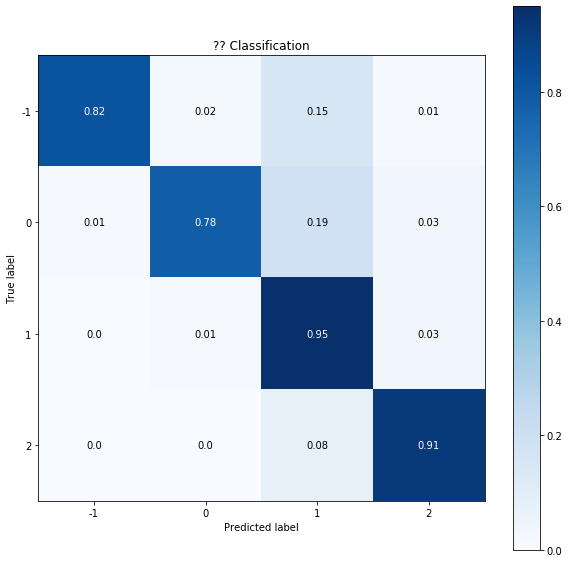

In [257]:
plot_confusion_matrix(y_train, y_pred_submission, normalize=True, figsize=(10,10), cmap="Blues")
plt.title("?? Classification")
plt.show()

In [261]:
y_pred_proba_submission = model.predict_proba(X_train)

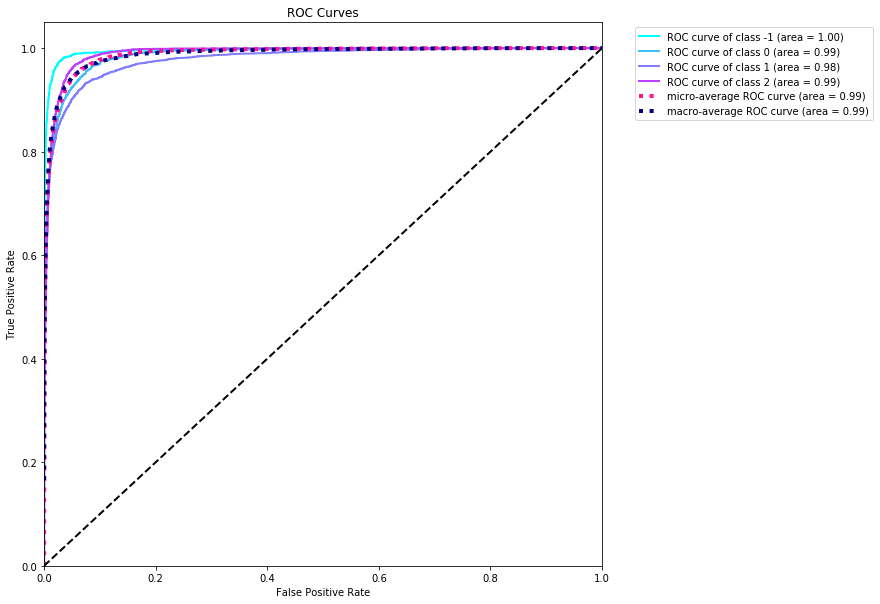

In [262]:
plot_roc(y_train, y_pred_proba_submission,figsize=(10,10),cmap='cool')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

??

In [173]:
df_submit = df_test[["tweetid"]]

In [174]:
df_submit["sentiment"] = y_pred_submission

In [175]:
write_submission(df_submit)

### Best Model:

In [307]:
classifier = MLPClassifier(max_iter=30, verbose=True)

In [308]:
parameter_space = {
    'hidden_layer_sizes' : [(10,),(20,)],
    'activation' : ['tanh', 'relu'],
    'solver' : ['sgd', 'adam'],
    'alpha' : [0.0001 , 0.05],
    'learning_rate' : ['constant', 'adaptive'],
}

In [309]:
classifier_model = GridSearchCV(classifier, parameter_space, n_jobs = -1, cv = 2)

In [310]:
model, vector, cm_df = test_model(
    classifier_model, 
    df_train_clean["message"], 
    df_train_clean["sentiment"], 
    vector_choice="count")
cm_df

Training data observations and features: (14225, 3162)
Iteration 1, loss = 1.46370029
Iteration 2, loss = 1.32146846
Iteration 3, loss = 1.18351352
Iteration 4, loss = 1.07507117
Iteration 5, loss = 0.98938051
Iteration 6, loss = 0.91653253
Iteration 7, loss = 0.85485650
Iteration 8, loss = 0.80525763
Iteration 9, loss = 0.76606719
Iteration 10, loss = 0.73522555
Iteration 11, loss = 0.71027396
Iteration 12, loss = 0.68952568
Iteration 13, loss = 0.67198050
Iteration 14, loss = 0.65681913
Iteration 15, loss = 0.64328582
Iteration 16, loss = 0.63147411
Iteration 17, loss = 0.62080651
Iteration 18, loss = 0.61124588
Iteration 19, loss = 0.60217976
Iteration 20, loss = 0.59398836
Iteration 21, loss = 0.58654225
Iteration 22, loss = 0.57962129
Iteration 23, loss = 0.57295499
Iteration 24, loss = 0.56683838
Iteration 25, loss = 0.56099205
Iteration 26, loss = 0.55570150
Iteration 27, loss = 0.55042999
Iteration 28, loss = 0.54560955
Iteration 29, loss = 0.54099171
Iteration 30, loss = 0.536

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


,-1: Pred_Anti_CC,0: Pred_Neutral_CC,1: Pred_Pro_CC,2: Pred_News_CC
-1: Act_Anti_CC,95,44,92,11
0: Act_Neutral_CC,26,185,231,37
1: Act_Pro_CC,26,88,1169,126
2: Act_News_CC,6,22,148,539


In [47]:
# mlpc_tfidf_pipe = Pipeline([("tfidf",  TfidfVectorizer()), ("mlpc", MLPClassifier(max_iter=10, verbose=True))])

In [ ]:
# params={
#     "tfidf__min_df": [1, 2, 3, 4, 5, 10],
#     "tfidf__max_df": [0.5, 0.6, 0.7],
#     "tfidf__ngram_range": [(1, 2)],
#     "mlpc__hidden_layer_sizes" : [(10,),(20,)],
#     "mlpc__activation": ["tanh", "relu"],
#     "mlpc__solver" : ["sgd", "adam"],
#     "mlpc__alpha" : [0.0001 , 0.05],
#     "mlpc__learning_rate" : ["constant", "adaptive"]
# }

In [48]:
# params={
#     "tfidf__min_df": [1, 2, 3, 4, 5, 10],
#     "tfidf__max_df": [0.5, 0.6, 0.7],
#     "tfidf__ngram_range": [(1, 2)],
#     "mlpc__hidden_layer_sizes" : [(20,)],
#     "mlpc__activation": ["relu"],
#     "mlpc__solver" : ["adam"],
#     "mlpc__alpha" : [0.05],
#     "mlpc__learning_rate" : ["constant"]
# }

In [50]:
# Kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid = GridSearchCV(mlpc_tfidf_pipe, param_grid=params, n_jobs=-1, cv=Kfold, verbose=3, scoring="f1_micro")

In [291]:
# grid.fit(X_train, y_train)

In [292]:
# Best parameter set
print('Best parameters found:\n', classifier_model.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}


In [293]:
# model = grid.best_estimator_

In [294]:
# y_pred_submission = model.predict(df_test_clean["message"])

In [295]:
# df_submit = df_test[["tweetid"]]

In [296]:
# df_submit["sentiment"] = y_pred_submission

In [297]:
df_submit = subm_df(model, df_test_clean["message"], vector, df_test_clean[["tweetid"]])

In [298]:
write_submission(df_submit)

# Results for Submission / Deploy Model
Show model and steps of model used for API model.

### Random forest count was used

In [ ]:
import pickle
def pickl_item(path, item):
        with open(path,'wb') as file:
            pickle.dump(item, file)
            return

In [ ]:
vect_save_path = "api_stremlit/countvec_randfr_1.pkl"
pickl_item(vect_save_path, c_vectorizer)

In [ ]:
model_save_path = "api_stremlit/model_randfr_1.pkl"
pickl_item(model_save_path, model_rfc)

# Conclusion
Models summary, insights gained ..

# References

# IGNORE FROM HERE DOWN

# PLAY

# predict -1 and 1, then predict 0, 2
Check hihgest

In [529]:
submit = df_test[["tweetid"]]

### predict 1 or -1

In [530]:
df_train_clean.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dioxide main cause global warming wait urlweb via @mashable,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt @rawstory researcher say three year act climate change late urlweb urlweb,698562
3,1,#todayinmaker # wired 2016 wa pivotal year war climate change urlweb,573736
4,1,rt @soynoviodetodas 2016 racist sexist climate change denying bigot leading poll #electionnight,466954


In [531]:
df_train_clean_1m1 = df_train_clean[df_train_clean["sentiment"].isin([-1,1])]

In [532]:
df_train_clean_1m1.shape

(9826, 3)

In [533]:
train_cv, test_cv, vector = feat_CountVec(df_train_clean_1m1["message"], df_test_clean["message"], ngram_range=(1, 1))

In [534]:
(X_train, y_train), (X_test, y_test) = tt_split(train_cv, df_train_clean_1m1["sentiment"])

In [535]:
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [536]:
pred_lr = model_lr.predict_proba(test_cv)

In [537]:
model_lr.classes_

array([-1,  1], dtype=int64)

In [538]:
t = pred_lr*100
t.astype(int)

array([[ 0, 99],
       [ 2, 97],
       [ 1, 98],
       ...,
       [ 0, 99],
       [54, 45],
       [ 9, 90]])

In [539]:
submit[model_lr.classes_] = pred_lr

C:\Users\leon1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\leon1\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [540]:
submit

,tweetid,-1,1
0,169760,0.005559,0.994441
1,35326,0.028753,0.971247
2,224985,0.010834,0.989166
3,476263,0.017268,0.982732
4,872928,0.094082,0.905918
...,...,...,...
10541,895714,0.054278,0.945722
10542,875167,0.109290,0.890710
10543,78329,0.007220,0.992780
10544,867455,0.545451,0.454549


## predict 0, 2

In [541]:
df_train_clean_02 = df_train_clean[df_train_clean["sentiment"].isin([0,2])]

In [542]:
df_train_clean_02.shape

(5993, 3)

In [543]:
train_cv, test_cv, vector = feat_CountVec(df_train_clean_02["message"], df_test_clean["message"], ngram_range=(1, 1))

In [544]:
(X_train, y_train), (X_test, y_test) = tt_split(train_cv, df_train_clean_02["sentiment"])

In [545]:
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=300)

In [546]:
pred_lr = model_lr.predict_proba(test_cv)

In [547]:
model_lr.classes_

array([0, 2], dtype=int64)

In [548]:
t = pred_lr*100
t.astype(int)

array([[22, 77],
       [43, 56],
       [21, 78],
       ...,
       [28, 71],
       [99,  0],
       [33, 66]])

In [549]:
submit[model_lr.classes_] = pred_lr

C:\Users\leon1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\leon1\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [550]:
submit

,tweetid,-1,1,0,2
0,169760,0.005559,0.994441,0.220728,0.779272
1,35326,0.028753,0.971247,0.437102,0.562898
2,224985,0.010834,0.989166,0.213054,0.786946
3,476263,0.017268,0.982732,0.993747,0.006253
4,872928,0.094082,0.905918,0.857036,0.142964
...,...,...,...,...,...
10541,895714,0.054278,0.945722,0.334677,0.665323
10542,875167,0.109290,0.890710,0.017714,0.982286
10543,78329,0.007220,0.992780,0.280770,0.719230
10544,867455,0.545451,0.454549,0.992443,0.007557


### combine

In [551]:
submit['sentiment'] = submit[[-1, 1, 0, 2]].max(axis=1)

C:\Users\leon1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [552]:
submit['sentiment'] = submit[[-1, 1, 0, 2]].idxmax(axis=1)

C:\Users\leon1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [553]:
submit

,tweetid,-1,1,0,2,sentiment
0,169760,0.005559,0.994441,0.220728,0.779272,1
1,35326,0.028753,0.971247,0.437102,0.562898,1
2,224985,0.010834,0.989166,0.213054,0.786946,1
3,476263,0.017268,0.982732,0.993747,0.006253,0
4,872928,0.094082,0.905918,0.857036,0.142964,1
...,...,...,...,...,...,...
10541,895714,0.054278,0.945722,0.334677,0.665323,1
10542,875167,0.109290,0.890710,0.017714,0.982286,2
10543,78329,0.007220,0.992780,0.280770,0.719230,1
10544,867455,0.545451,0.454549,0.992443,0.007557,0


In [493]:
submit = submit[['tweetid', 'sentiment']]
submit

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,0
4,872928,1
...,...,...
10541,895714,1
10542,875167,2
10543,78329,1
10544,867455,0


In [495]:
submit['sentiment'].value_counts()

 1    6516
 0    2379
 2    1490
-1     161
Name: sentiment, dtype: int64

In [498]:
estimate = {
    -1: 0.08771,
    0: 0.13833,
    1: 0.54148,
    2: 0.23245 
}

In [499]:
for k, v in estimate.items():
    print(k, v*submit.shape[0])

-1 924.98966
0 1458.8281800000002
1 5710.448079999999
2 2451.4177


In [504]:
write_submission(submit)

### ??